<a href="https://colab.research.google.com/github/sahoodibyaranjan/Colabfiles/blob/main/MAZE_SIMULATOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks


/content/drive/My Drive/Colab Notebooks


In [ ]:
%ls

ANN_numpy.ipynb   maze_100.png  MAZE_SIMULATOR.ipynb  webscraping.ipynb
image_test.ipynb  maze_10.png   Monalisa.ipynb
image_test.py     maze_1.png    Untitled3.ipynb
maze_0.png        maze_210.png  Untitled4.ipynb


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
import math
from PIL import Image, ImageDraw
from IPython.display import display

scalefactor = 40
border = 5
markersize = 3
Linewidth = 2

def coord(x):
  if type(x) is list:
    return [coord(elem) for elem in x]
  elif type(x) is tuple:
    return tuple(coord(elem) for elem in x)
  else:
    return int(scalefactor*x) + border

def marker(x):
  return list(i - markersize for i in coord(x)) + list(i + markersize for i in coord(x))

def showmaze(m,i):
  width = m['dimensions'][0]
  height = m['dimensions'][1]
  img = Image.new('RGB', (int(width*scalefactor) + 2*border , int(height*scalefactor) + 2*border), 'white')
  img1 = ImageDraw.Draw(img)
  img1.rectangle(coord([0.0, 0.0, width, height]), None, 'black')
  img1.ellipse(marker(m['position']), 'black')
  img1.ellipse(marker(m['goal']), 'red')
  for obstacle in m['obstacles']:
    img1.line(coord(obstacle), 'black', Linewidth)
  mazeNamePNG = "maze_" + str(i) + ".png"
  img.save(mazeNamePNG)
  display(img)

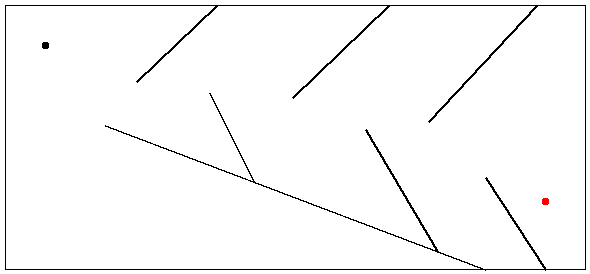

In [ ]:
mediumMaze = {
    'dimensions': (14.5, 6.6),

    # obstacles are lines specified as [(x1,y1),(x2,y2)],
    #   where (0,0) is the top-left corner of the world
    # the four walls around the world are implicit and don't need to be specified
    'obstacles': [[(2.5, 3.0),(12.0, 6.6)], [(5.1, 2.2), (6.2, 4.4)],
                  [(9.0, 3.1), (10.8, 6.15)], [(12.0, 4.3), (13.5, 6.6)],
                  [(3.3, 1.9), (5.3, 0.0)], [(7.2, 2.3), (9.6, 0.0)],
                  [(10.6, 2.9), (13.3, 0.0)]],
   
    'position': (1.0, 1.0),
    'heading': 0, # in radians. 0 is to the right (+x axis); increasing heading rotates clockwise
    'goal': (13.5, 4.9),
}

showmaze(mediumMaze,0)

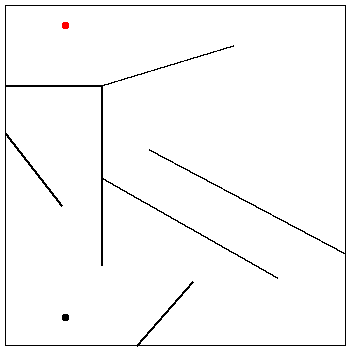

In [ ]:
hardMaze = {
    'dimensions': (8.5, 8.5),

    'obstacles': [[(0.0, 2.0), (2.4, 2.0)], [(2.4, 2.0), (5.7, 1.0)],
                  [(2.4, 2.0), (2.4, 6.5)], [(0.0, 3.2), (1.4, 5.0)],
                  [(2.4, 4.3), (6.8, 6.8)], [(3.3, 8.5), (4.7, 6.9)],
                  [(3.6, 3.6), (8.5, 6.2)]],
   
    'position': (1.5, 7.8),
    'heading': 0,
    'goal': (1.5, 0.5),
}

showmaze(hardMaze,0)

In [ ]:
# robot max speed, in world units per timestep
speed = 0.1

# epsilon distance for considering goal reached, collisions, etc.
epsilon = 0.01
sqEpsilon = epsilon**2

# interval to update visualization
visInterval = 1

# max simulation timesteps
timeout = 400

In [ ]:
import random
def randomController(sensors):
  # ignores sensors
  return (random.uniform(-1, 1), random.uniform(-1,1))

In [ ]:
def goStraight(sensors):
  # ignores sensors
  return (1.0, 0.0)

In [ ]:
def goStraightAvoid(sensors):
  # go left-forward, forward, or right-forward, depending on which direction is furthest from obstacles
  if sensors[2] >= sensors[1] and sensors[2] >= sensors[3]:
    return (1.0, 0.0)        # go straight
  elif sensors[1] > sensors[3]:
    return (1.0, -0.25) # turn 45 degrees left
  return (1.0, 0.25)  # turn 45 degrees right

In [ ]:
#goStraightAvoid(sensors=rangeSensorDirections)
#goStraight(sensors=rangeSensorDirections + wedgeSensors)
goStraight(wedgeSensors)

(1.0, 0.0)

In [ ]:
from shapely.geometry import Point, LineString
import copy

def sqDistance(pos1, pos2):
  return (pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2

def isGoal(state):
  return sqDistance(state['position'], state['goal']) < sqEpsilon

# direction a given offset from the current heading, after normalizing (all in radians)
def newHeading(currentHeading, amount):
  return (currentHeading + amount) % (math.pi * 2.0)

# distance to the nearest obstacle in a given direction
def rangeSensor(pos, direction, obstacles, maxDist):
  pos2 = (pos[0] + math.cos(direction) * maxDist,
          pos[1] + math.sin(direction) * maxDist)
  testray = LineString([pos, pos2])
  collisions = [testray.intersection(obstacle) for obstacle in obstacles]
  posPt = Point(pos[0], pos[1])
  distances = [posPt.distance(c) for c in collisions if c]
  return min(distances)



In [ ]:
def runSimulation(initState, controller):
  state = copy.copy(initState)
  timestep = 0

  # add the 4 edges as pseudo-obstacles,
  # and cache the shapely.geometry.LineString versions, since obstacles don't move
  obstacles = [LineString(obstacle) for obstacle in state['obstacles']]
  (width, height) = state['dimensions']
  obstacles += [LineString([(0.0, 0.0), (width, 0.0)]),
                LineString([(0.0, 0.0), (0.0, height)]),
                LineString([(width, 0.0), (width, height)]),
                LineString([(0.0, height), (width, height)])]
  maxDist = math.sqrt(width**2 + height**2) # max distance between points in the maze

  print("Initial state:")
  showmaze(state,timestep)
    
  while not isGoal(state) and timestep < timeout:
    # bookkeeping and state vis
    timestep += 1
    if timestep % visInterval == 0:
      print(f"Step {timestep}:")
      showmaze(state, timestep)

    # update sensors
    # six range sensors, angled (in order): left, left-center, center, right-center, right, back
    rangeSensorDirections = [-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi]
    rangeSensors = [rangeSensor(state['position'], newHeading(state['heading'], direction), obstacles, maxDist)
                    for direction in rangeSensorDirections]
    # wedge sensor, as a 4-element one-hot encoding
    # angleToGoal is relative to heading, normalized to [0, 2pi], where 0 is forward
    angleToGoal = (math.atan2(state['goal'][1] - state['position'][1], state['goal'][0] - state['position'][0]) - state['heading']) % (math.pi * 2.0)
    if 0.25*math.pi < angleToGoal <= 0.75*math.pi:   # right
      wedgeSensors = [0.0, 0.0, 1.0, 0.0]
    elif 0.75*math.pi < angleToGoal <= 1.25*math.pi: # rear
      wedgeSensors = [0.0, 0.0, 0.0, 1.0]
    elif 1.25*math.pi < angleToGoal <= 1.75*math.pi: # left
      wedgeSensors = [1.0, 0.0, 0.0, 0.0]
    else:                                            # forward
      wedgeSensors = [0.0, 1.0, 0.0, 0.0]
    sensors = rangeSensors + wedgeSensors
#print("sensor data", sensors)
    # query the controller
    (forwardBack, leftRight) = controller(sensors)
    movement = forwardBack * speed
    state['heading'] = newHeading(state['heading'], leftRight * math.pi)

    # collision detection and position updating:
    # since we only have a point agent and line-segment obstacles, we can skip a
    #   'real' physics engine and just look for whether our path on the next
    #   timestep would intersect an obstacle
    pos = state['position']
    if (movement >= 0.0):
      effectiveHeading = state['heading']
      effectiveMovement = movement
    else:
      effectiveHeading = newHeading(state['heading'], 2*math.pi)
      effectiveMovement = -movement
    distToCollision = rangeSensor(pos, effectiveHeading, obstacles, maxDist)
    if distToCollision <= effectiveMovement: # collision
      # bounce back epsilon from the collision point
      newpos = (pos[0] + math.cos(effectiveHeading) * (distToCollision - epsilon),
                pos[1] + math.sin(effectiveHeading) * (distToCollision - epsilon))
    else:
      newpos = (pos[0] + math.cos(effectiveHeading) * effectiveMovement,
                pos[1] + math.sin(effectiveHeading) * effectiveMovement)
    state['position'] = newpos

  if isGoal(state):
    print(f"Goal reached in {timestep} steps:")
    showmaze(state, timestep)
  else:
    print(f"Timeout at {timestep} steps:")
    showmaze(state, timestep)

In [ ]:
x= np.array([[-math.pi/2], [-math.pi/4], [0], [math.pi/4], [math.pi/2], [math.pi]])
#rangeSensorDirections = np.array(x)
#rangeSensorDirections.resize((6,5))
y = np.pad(x, (0, 3), 'constant')
rangeSensorDirections = np.delete(y, (6,7,8), axis=0)
#print(y)
#print(type(x))
wedgeSensors =np.array([[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
#wedgeSensors.resize((5,6))
#y = [[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]
#wedgeSensors = np.array(y)
#print(wedgeSensors)
#Total = (rangeSensorDirections, wedgeSensors)
sensors = np.array(np.concatenate((rangeSensorDirections, wedgeSensors)))
#np.pad(sensors, [(0, 1), (0, 1)], mode='constant', constant_values=0)
#sensors = [[-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi],[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]]
print(sensors)
#result = np.zeros(wedgeSensors.shape)
#result[:rangeSensorDirections.shape[0],:rangeSensorDirections.shape[1]] = rangeSensorDirections
#rangeSensorDirections = [-math.pi/2, -math.pi/4, 0, math.pi/4, math.pi/2, math.pi]
#print(rangeSensorDirections)

[[-1.57079633  0.          0.          0.        ]
 [-0.78539816  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.78539816  0.          0.          0.        ]
 [ 1.57079633  0.          0.          0.        ]
 [ 3.14159265  0.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]]


In [ ]:
import numpy as np
import random

np.random.seed(0)
'''class Layer_Dense:
  def __init__(self, n_inputs, n_neurons):
    self.weights = np.random.randn(n_inputs, n_neurons)
    self.biases = np.zeros((1, n_neurons))
  def forward(self, inputs):
    self.output = np.dot(inputs, (self.weights).T) + self.biases
  

#layer1 = Layer_Dense(4,10)
#layer2 = Layer_Dense(4, 2)
#layer1.forward(sensors)
#print(layer1.output)
#print(type(weights))
print(np.random.randn(4, 10))'''

weights = np.random.randn(10,4)
#print(weights)
bias = np.zeros(1)
#print(bias)
Layer1_output= np.dot(sensors, np.array(weights).T) + bias
print(Layer1_output)


[[-2.77096695 -2.93355323  0.16213579 -1.19543526 -2.34689392  4.01022703
  -3.56532223 -2.40768396  1.39453059 -1.93253608]
 [-1.38548347 -1.46677662  0.0810679  -0.59771763 -1.17344696  2.00511351
  -1.78266111 -1.20384198  0.6972653  -0.96626804]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 1.38548347  1.46677662 -0.0810679   0.59771763  1.17344696 -2.00511351
   1.78266111  1.20384198 -0.6972653   0.96626804]
 [ 2.77096695  2.93355323 -0.16213579  1.19543526  2.34689392 -4.01022703
   3.56532223  2.40768396 -1.39453059  1.93253608]
 [ 5.54193389  5.86710646 -0.32427159  2.39087053  4.69378784 -8.02045405
   7.13064445  4.81536792 -2.78906118  3.86507216]
 [ 0.97873798  0.95008842  0.14404357  0.44386323  0.3130677   0.8644362
   0.04575852  0.15494743 -0.34791215 -0.38732682]
 [ 2.2408932  -0.15135721  1.45427351  0.33367433 -0.85409574 -0.74216502
  -0.18718385  0.37816252  0.15634897 -0.30230275]
 [ 1.7640

Initial state:


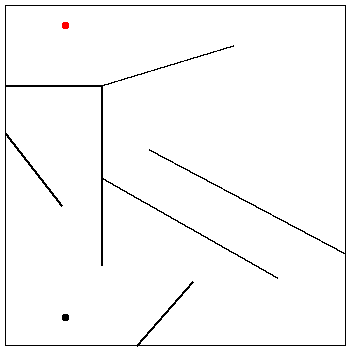

Step 1:


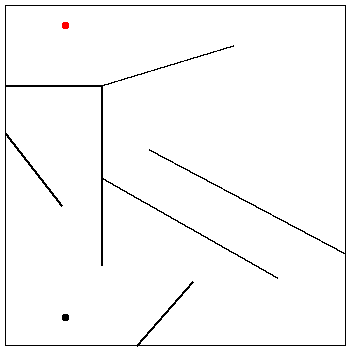

Step 2:


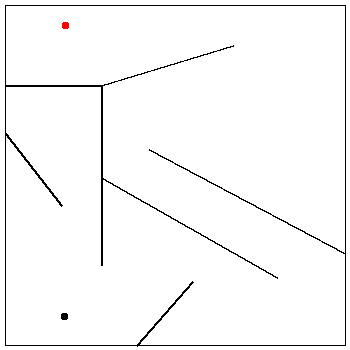

Step 3:


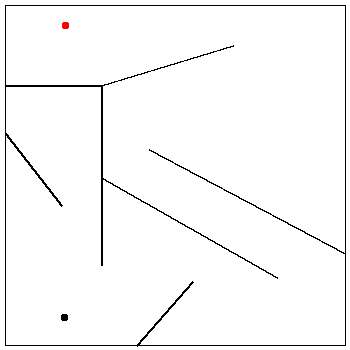

Step 4:


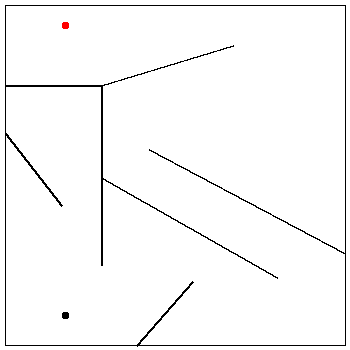

Step 5:


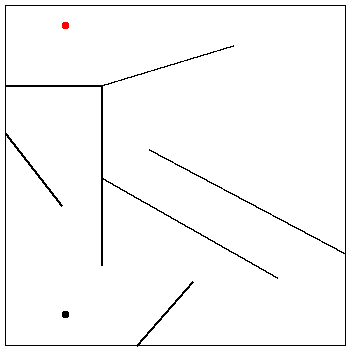

Step 6:


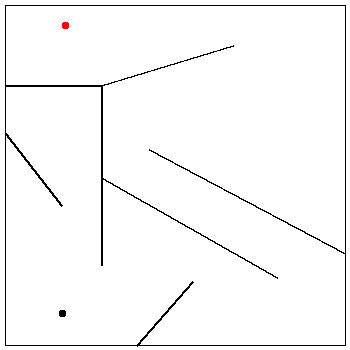

Step 7:


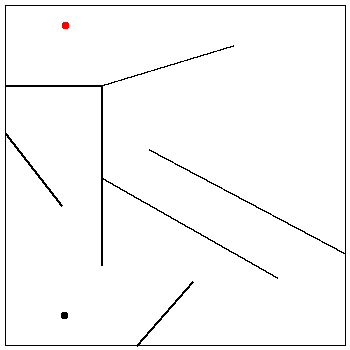

Step 8:


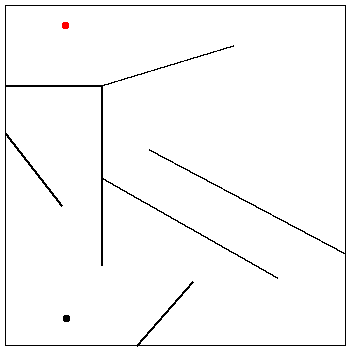

Step 9:


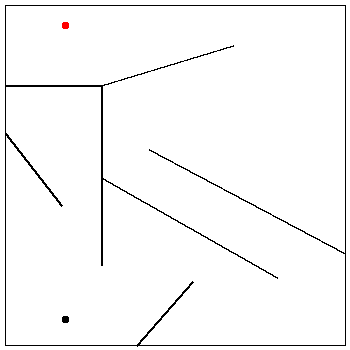

Step 10:


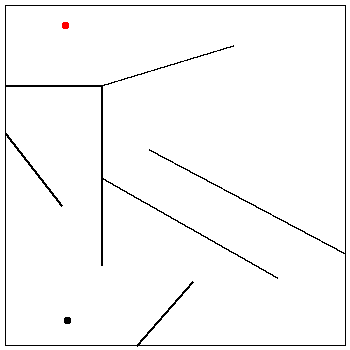

Step 11:


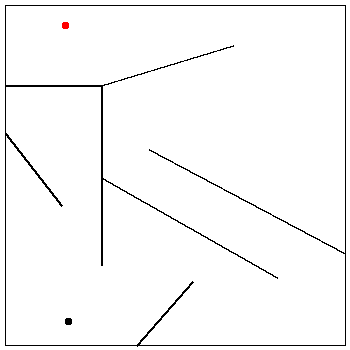

Step 12:


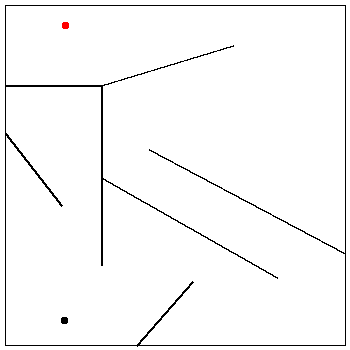

Step 13:


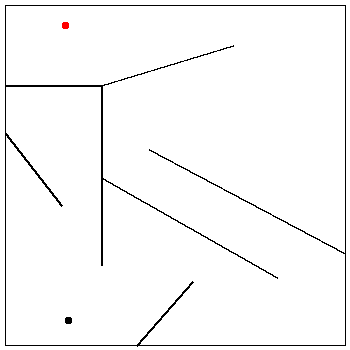

Step 14:


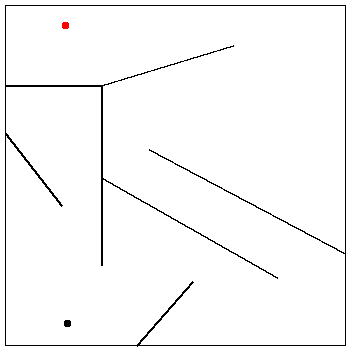

Step 15:


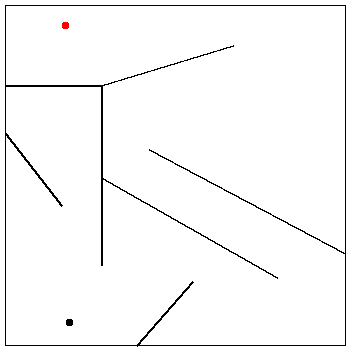

Step 16:


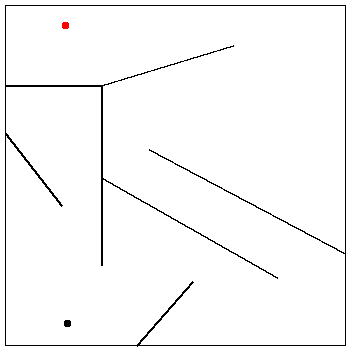

Step 17:


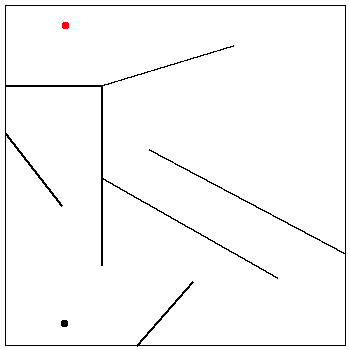

Step 18:


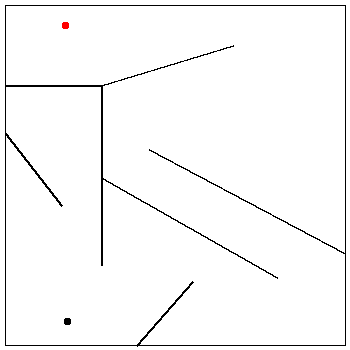

Step 19:


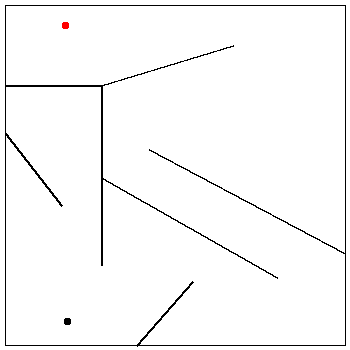

Step 20:


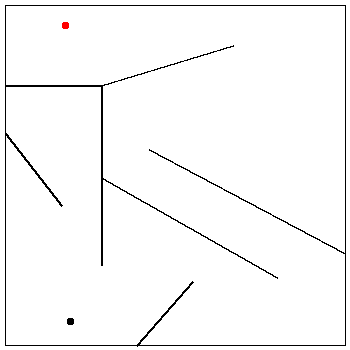

Step 21:


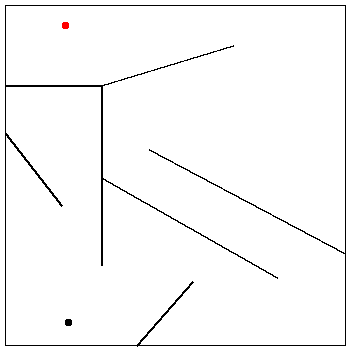

Step 22:


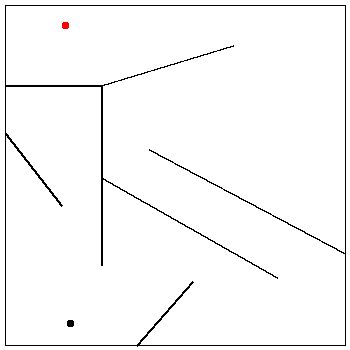

Step 23:


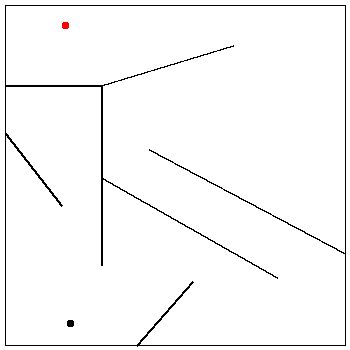

Step 24:


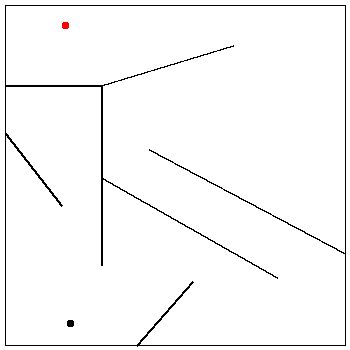

Step 25:


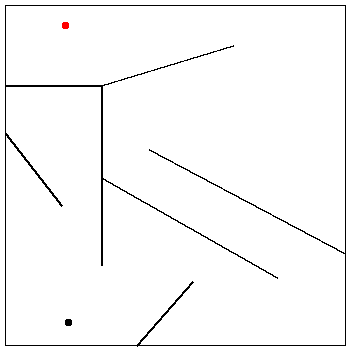

Step 26:


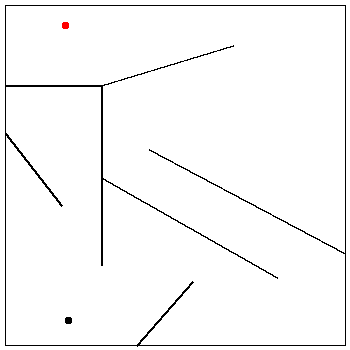

Step 27:


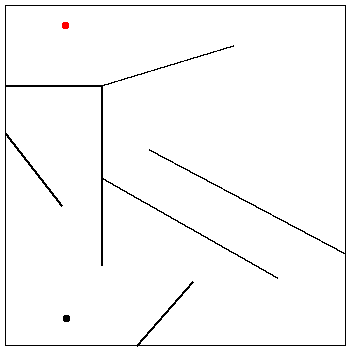

Step 28:


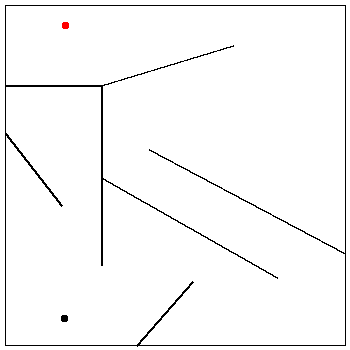

Step 29:


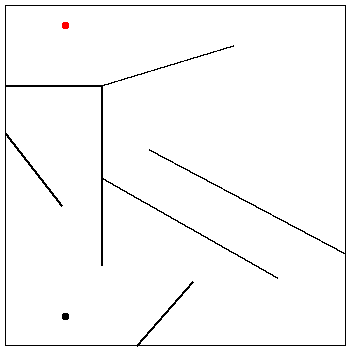

Step 30:


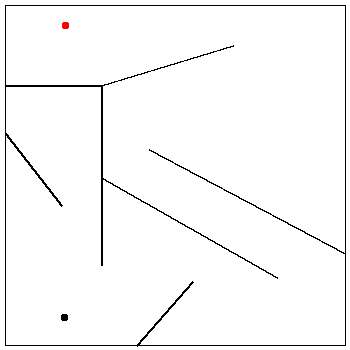

Step 31:


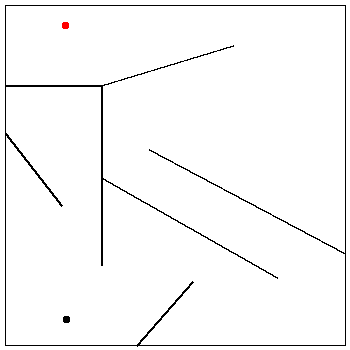

Step 32:


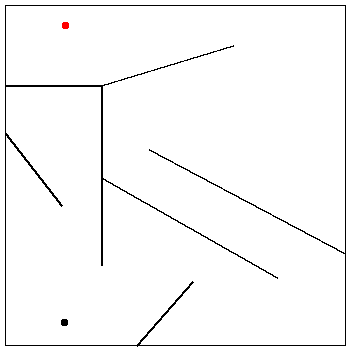

Step 33:


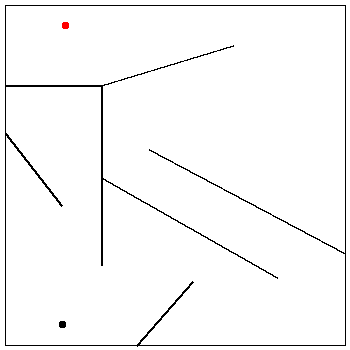

Step 34:


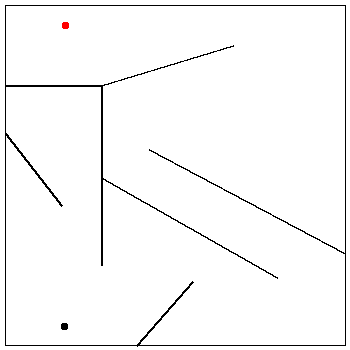

Step 35:


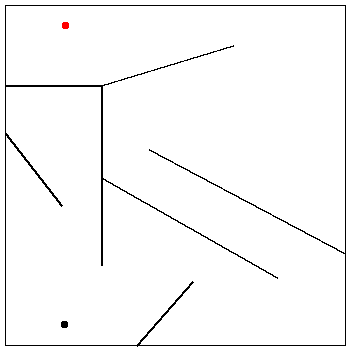

Step 36:


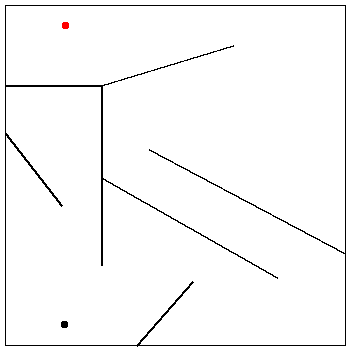

Step 37:


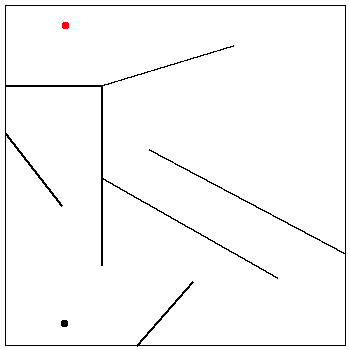

Step 38:


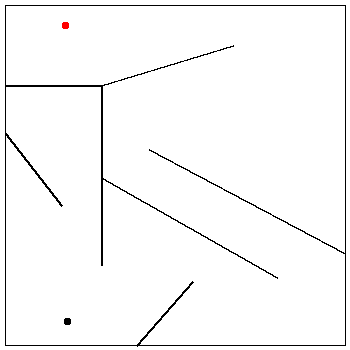

Step 39:


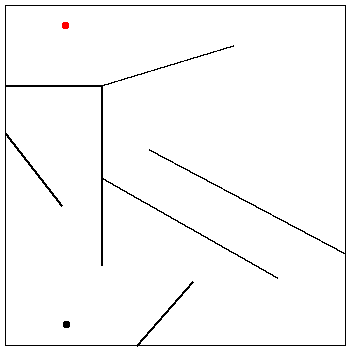

Step 40:


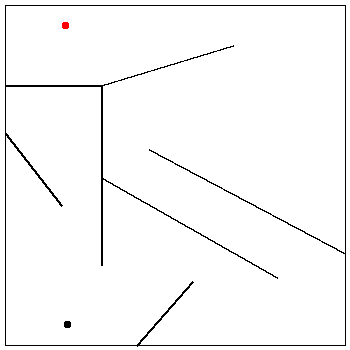

Step 41:


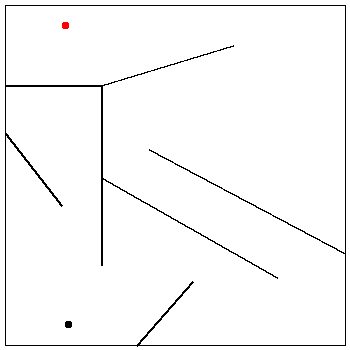

Step 42:


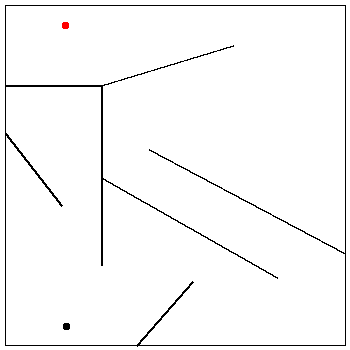

Step 43:


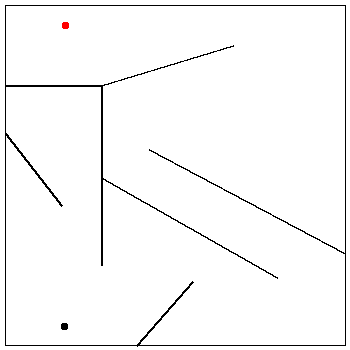

Step 44:


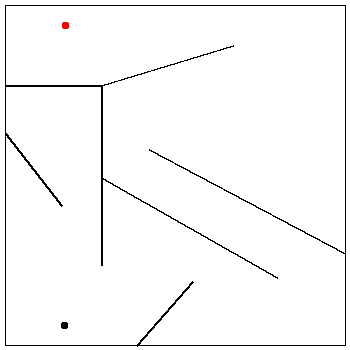

Step 45:


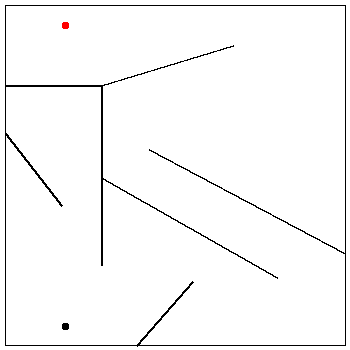

Step 46:


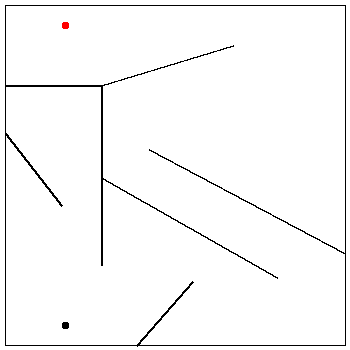

Step 47:


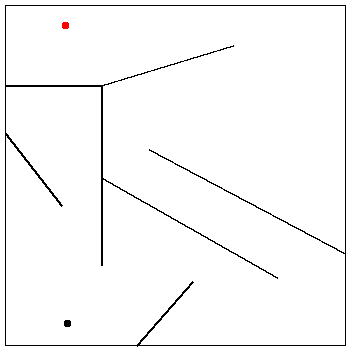

Step 48:


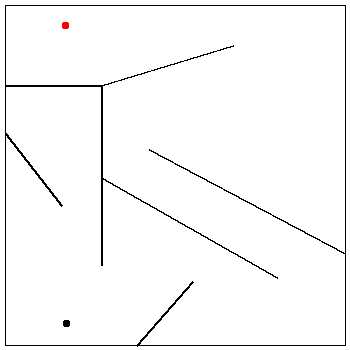

Step 49:


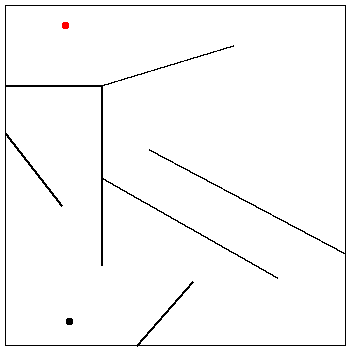

Step 50:


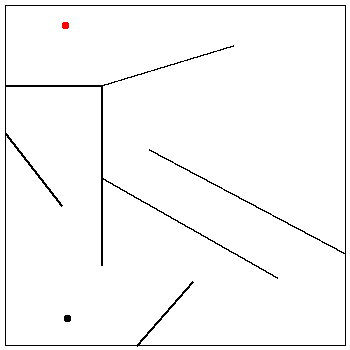

Step 51:


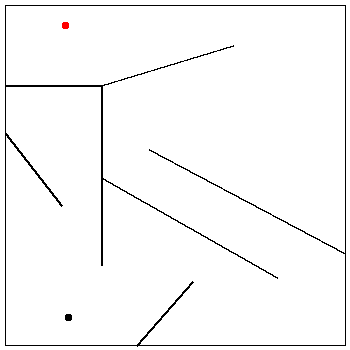

Step 52:


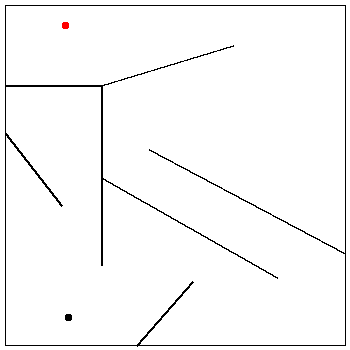

Step 53:


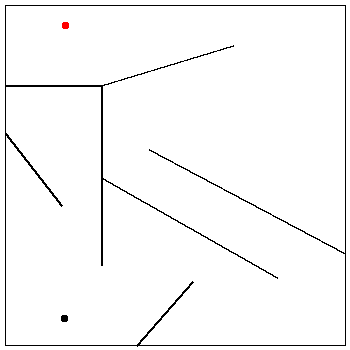

Step 54:


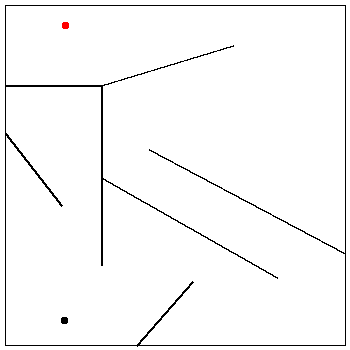

Step 55:


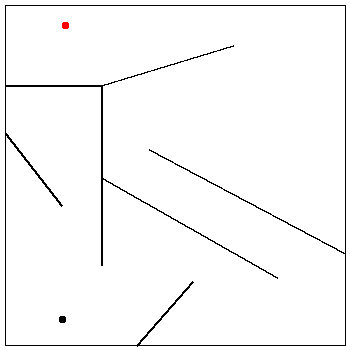

Step 56:


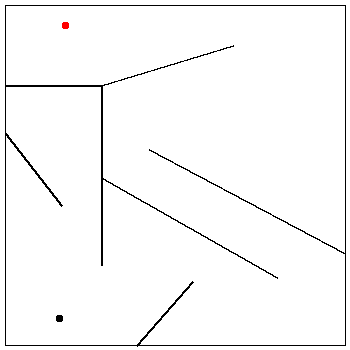

Step 57:


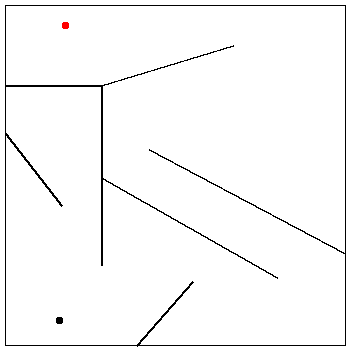

Step 58:


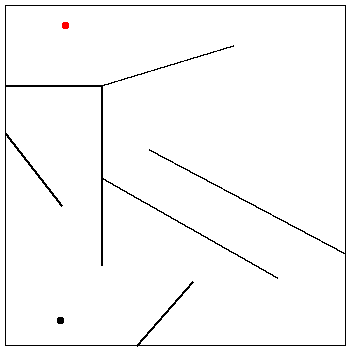

Step 59:


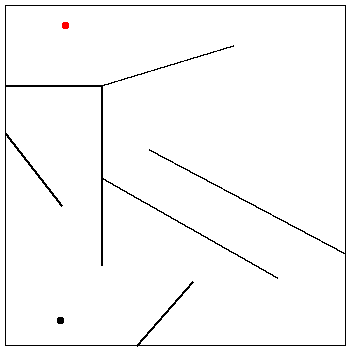

Step 60:


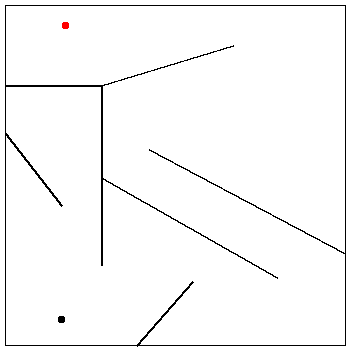

Step 61:


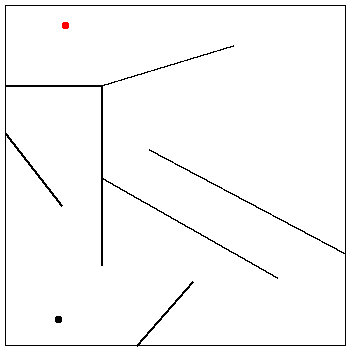

Step 62:


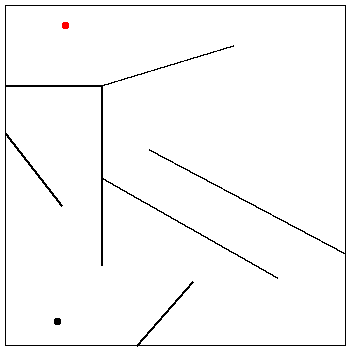

Step 63:


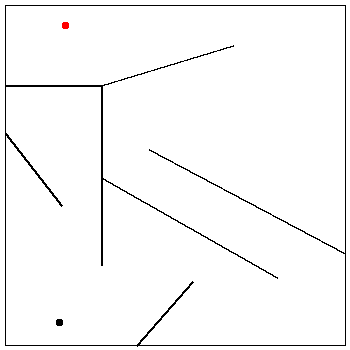

Step 64:


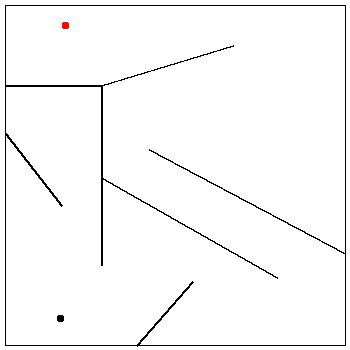

Step 65:


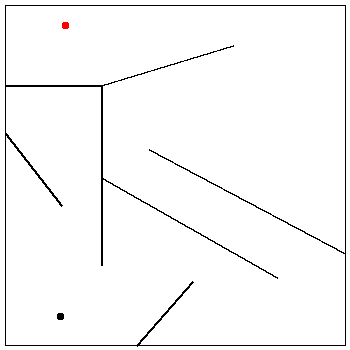

Step 66:


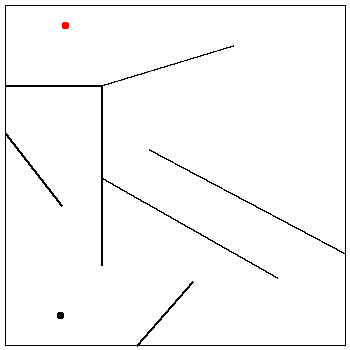

Step 67:


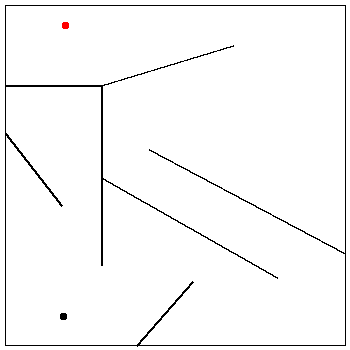

Step 68:


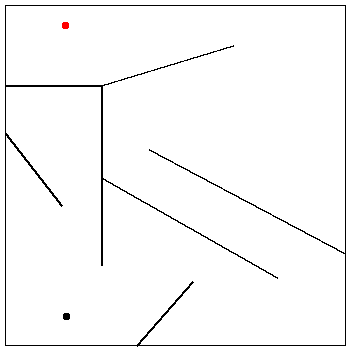

Step 69:


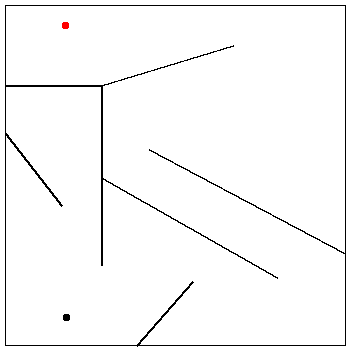

Step 70:


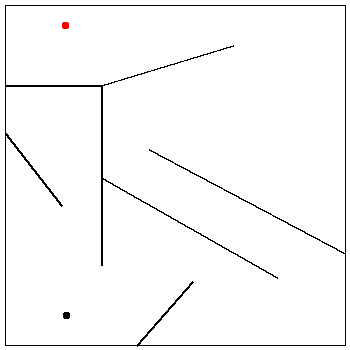

Step 71:


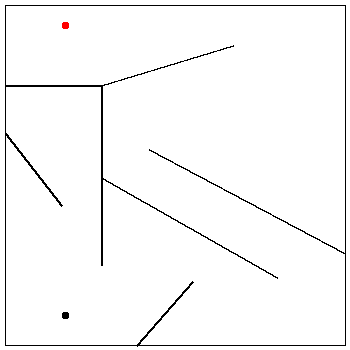

Step 72:


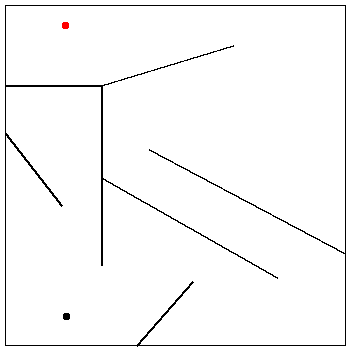

Step 73:


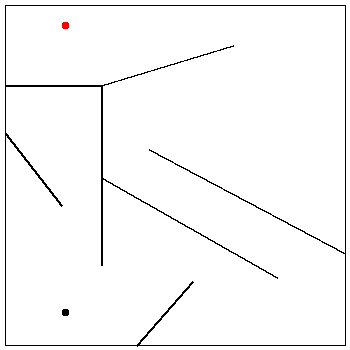

Step 74:


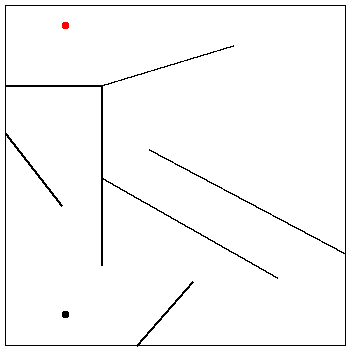

Step 75:


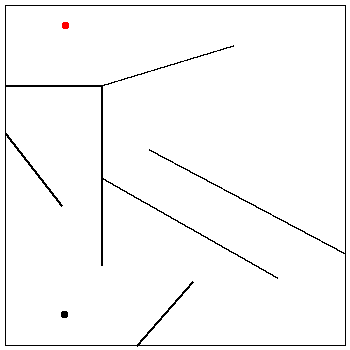

Step 76:


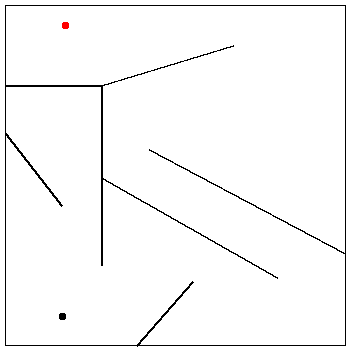

Step 77:


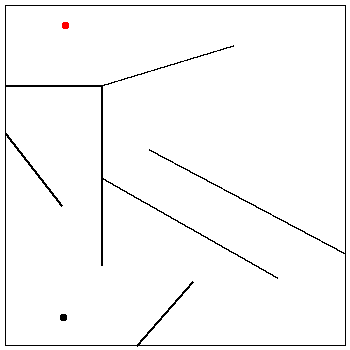

Step 78:


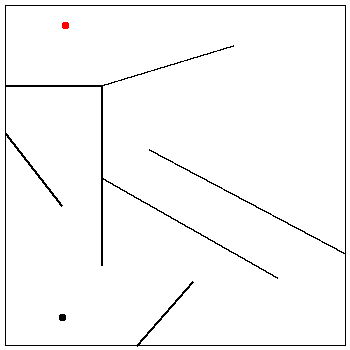

Step 79:


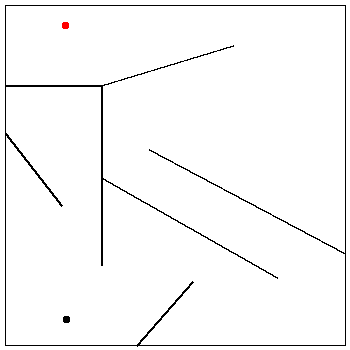

Step 80:


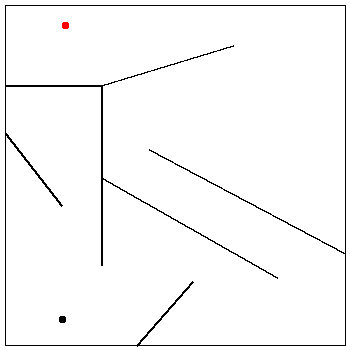

Step 81:


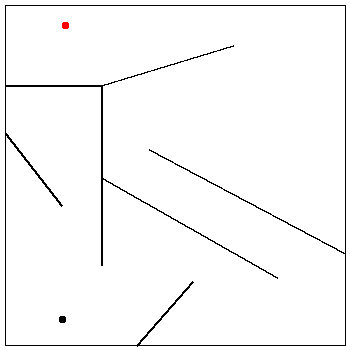

Step 82:


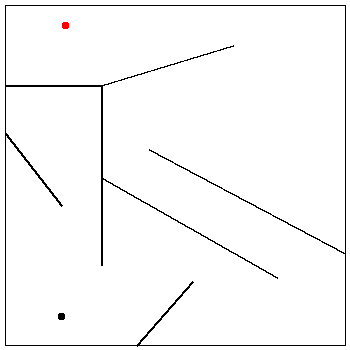

Step 83:


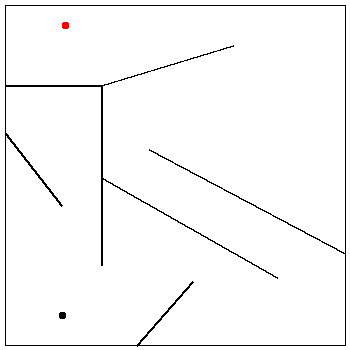

Step 84:


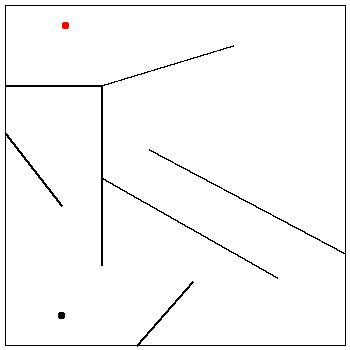

Step 85:


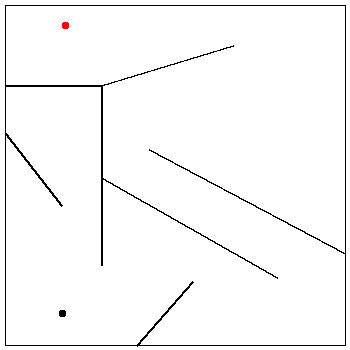

Step 86:


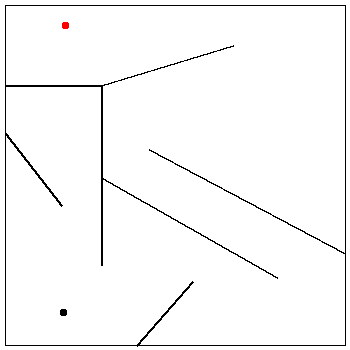

Step 87:


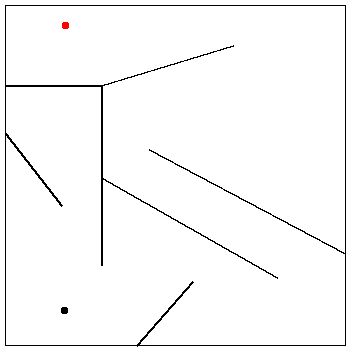

Step 88:


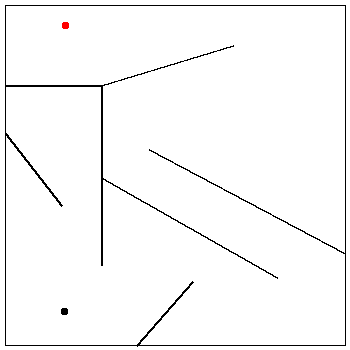

Step 89:


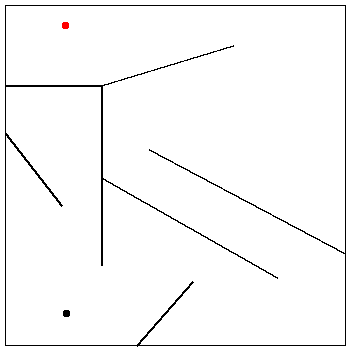

Step 90:


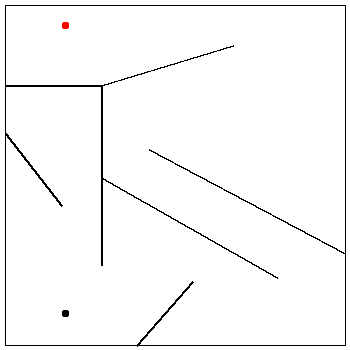

Step 91:


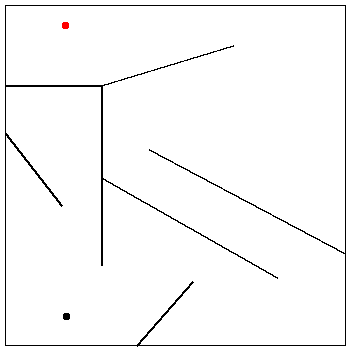

Step 92:


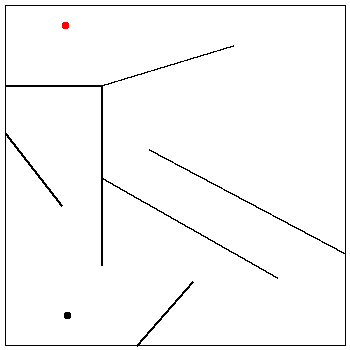

Step 93:


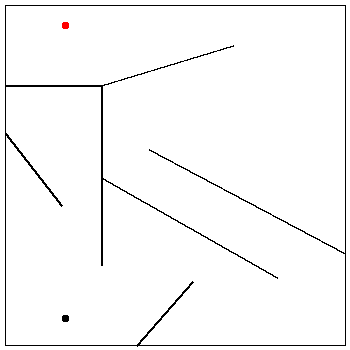

Step 94:


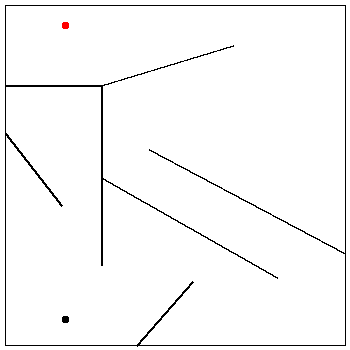

Step 95:


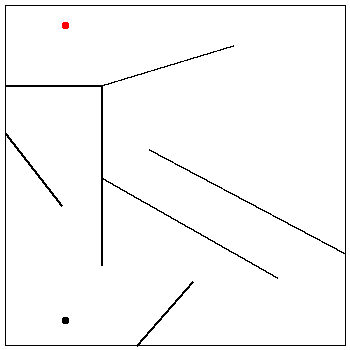

Step 96:


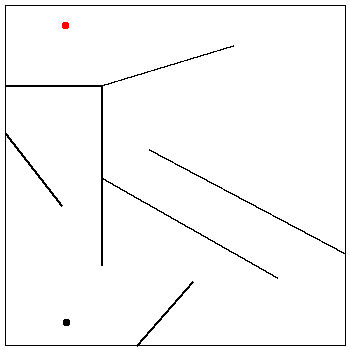

Step 97:


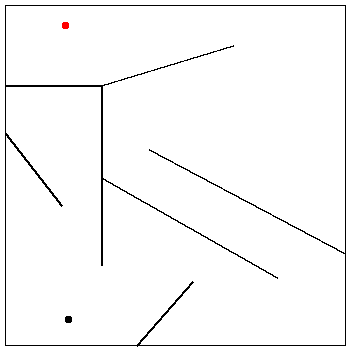

Step 98:


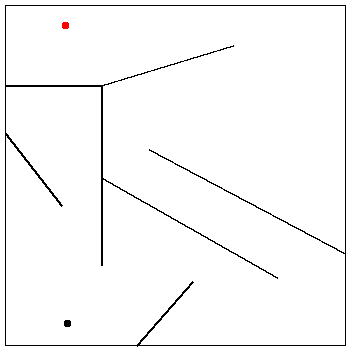

Step 99:


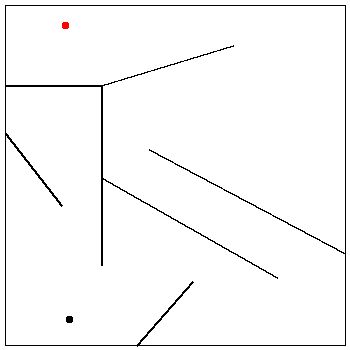

Step 100:


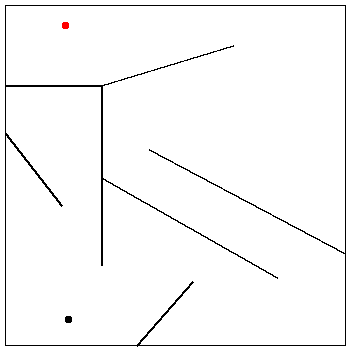

Step 101:


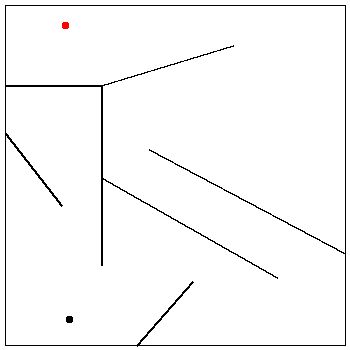

Step 102:


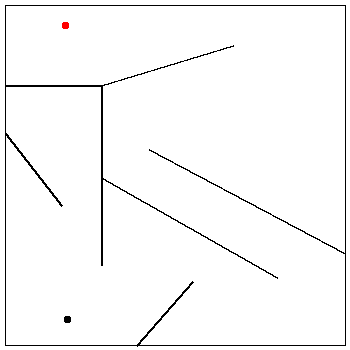

Step 103:


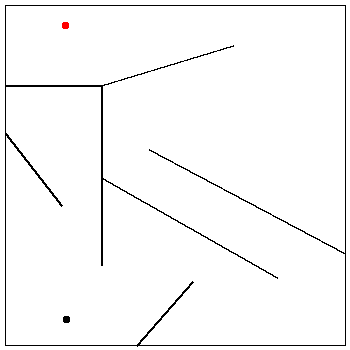

Step 104:


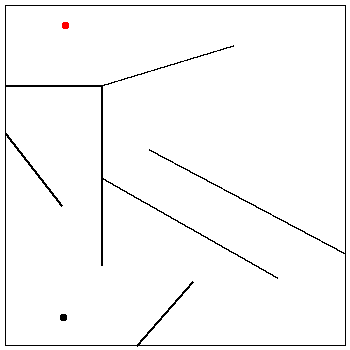

Step 105:


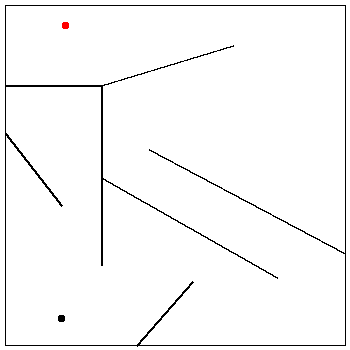

Step 106:


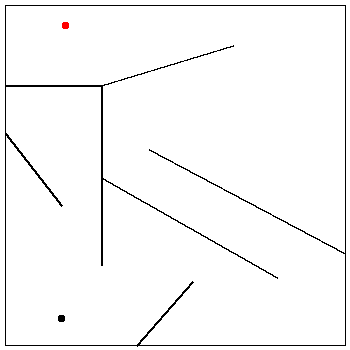

Step 107:


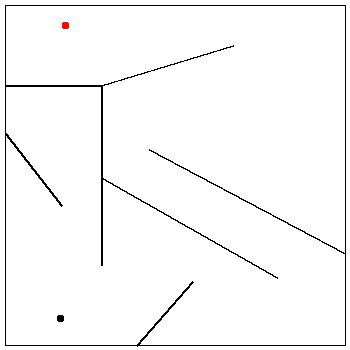

Step 108:


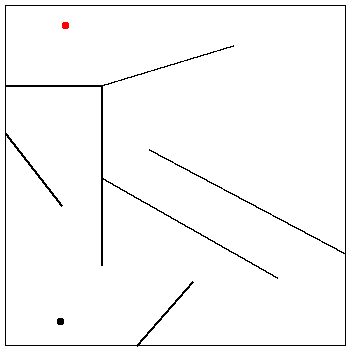

Step 109:


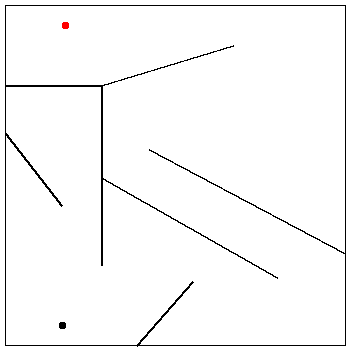

Step 110:


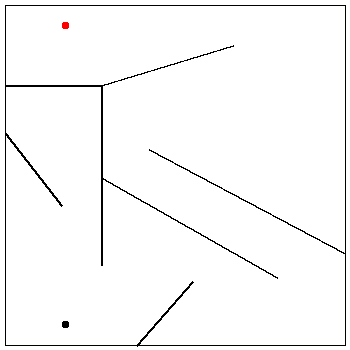

Step 111:


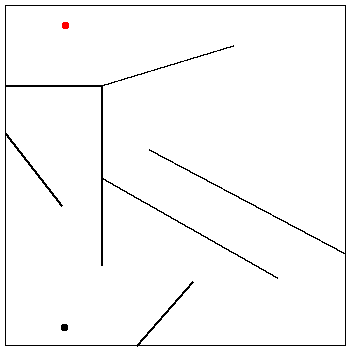

Step 112:


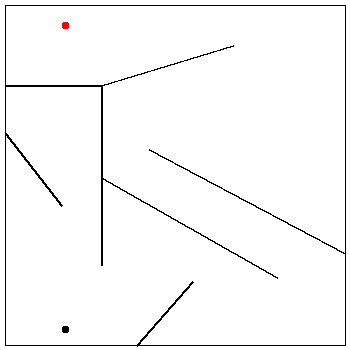

Step 113:


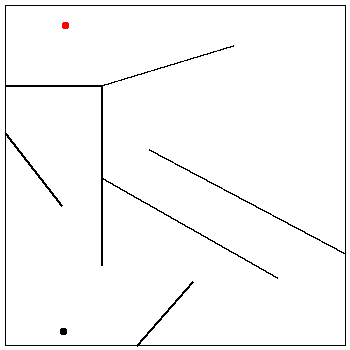

Step 114:


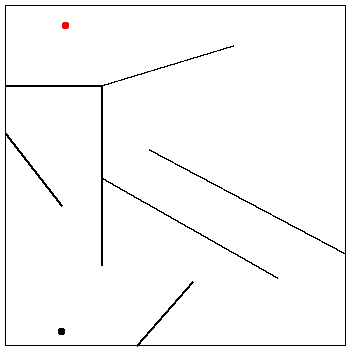

Step 115:


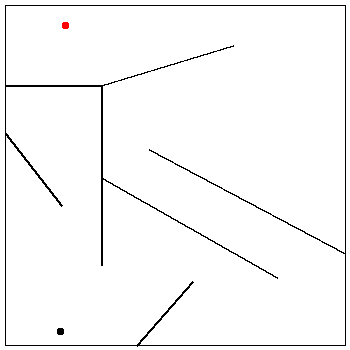

Step 116:


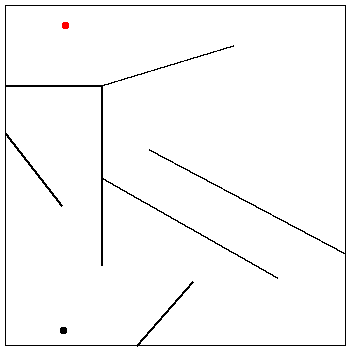

Step 117:


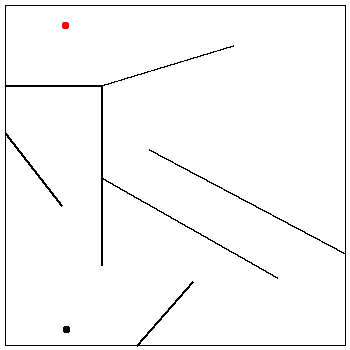

Step 118:


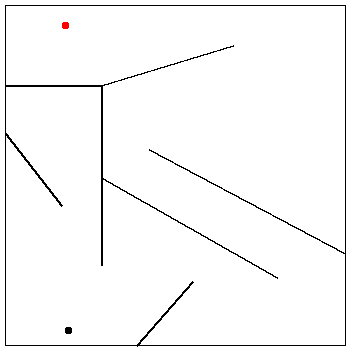

Step 119:


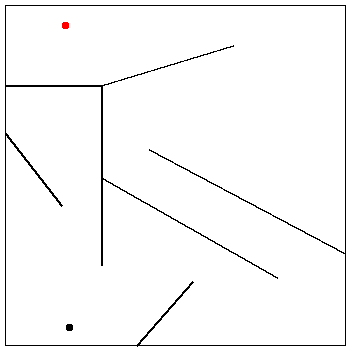

Step 120:


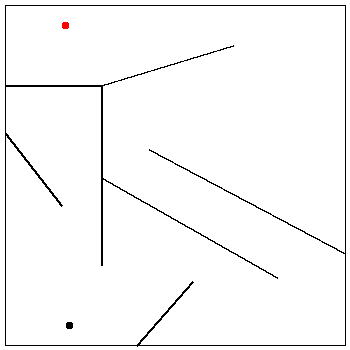

Step 121:


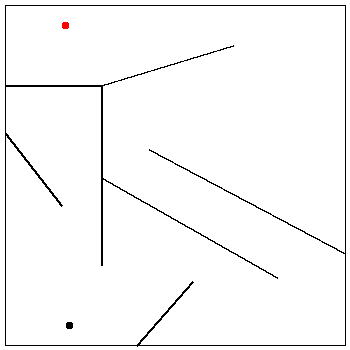

Step 122:


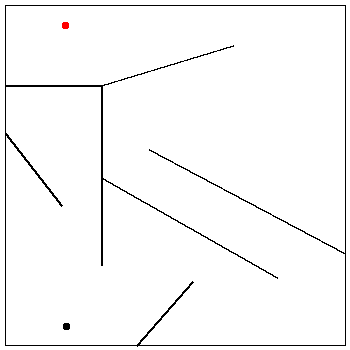

Step 123:


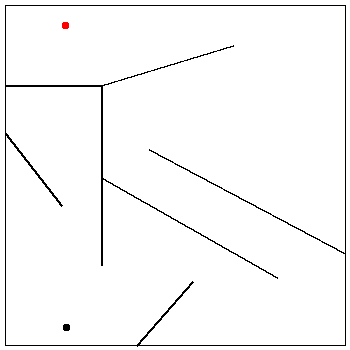

Step 124:


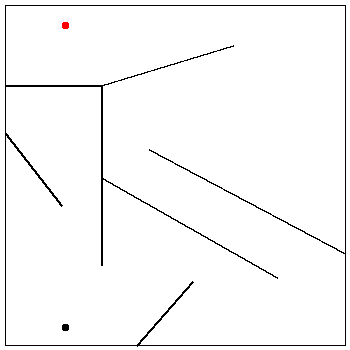

Step 125:


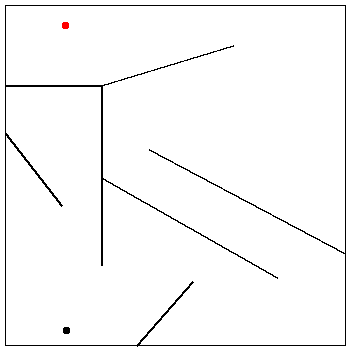

Step 126:


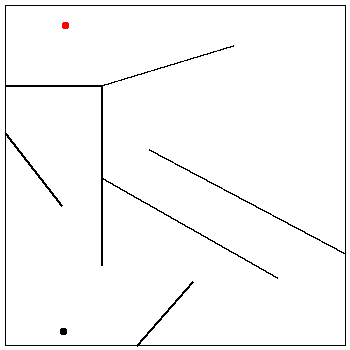

Step 127:


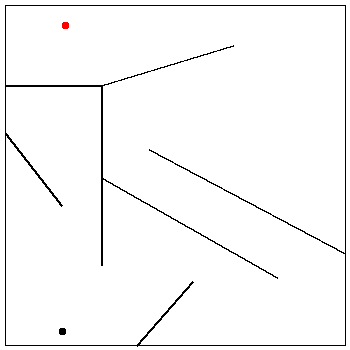

Step 128:


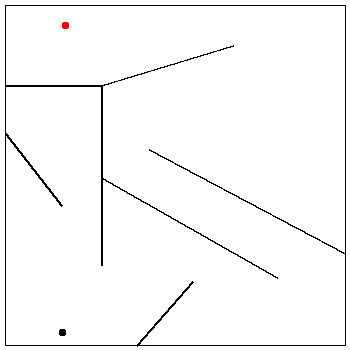

Step 129:


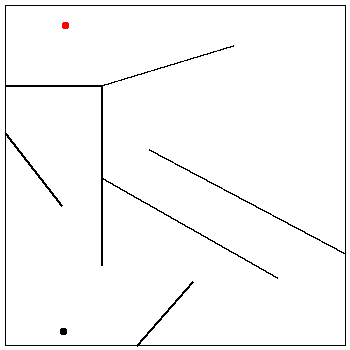

Step 130:


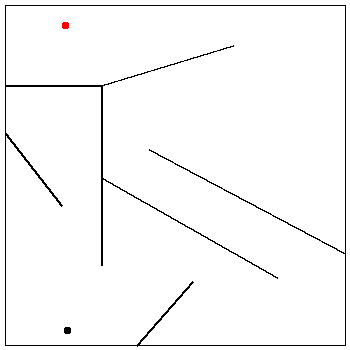

Step 131:


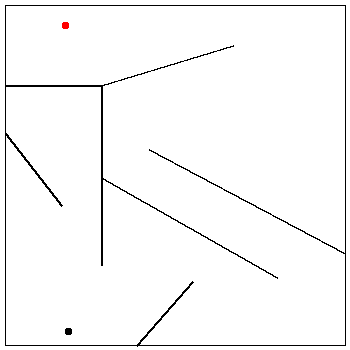

Step 132:


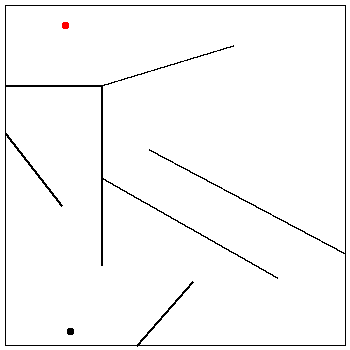

Step 133:


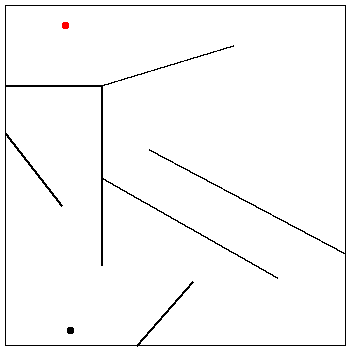

Step 134:


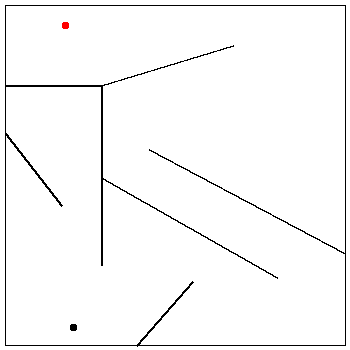

Step 135:


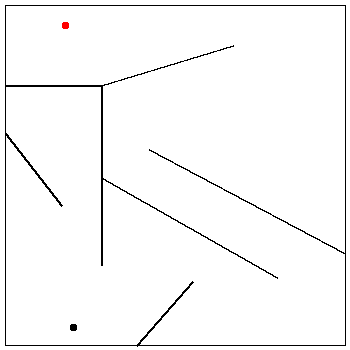

Step 136:


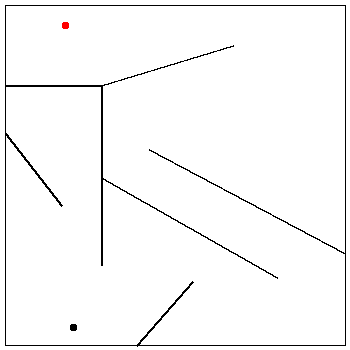

Step 137:


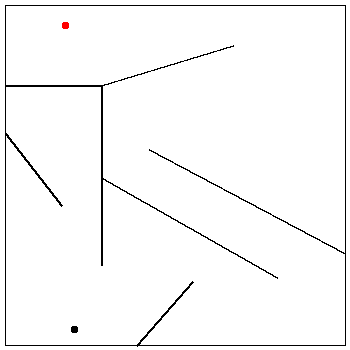

Step 138:


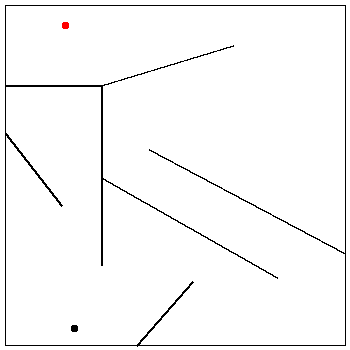

Step 139:


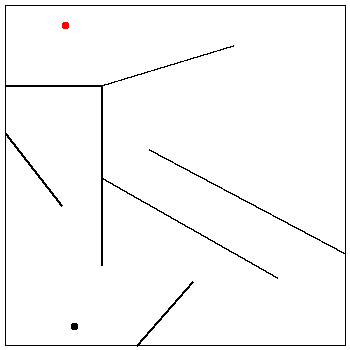

Step 140:


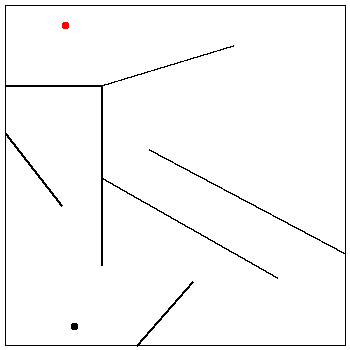

Step 141:


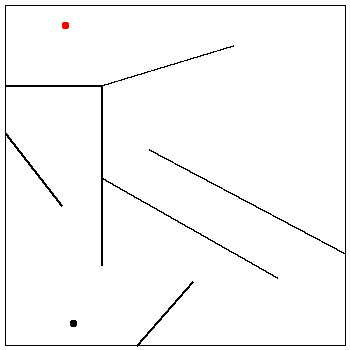

Step 142:


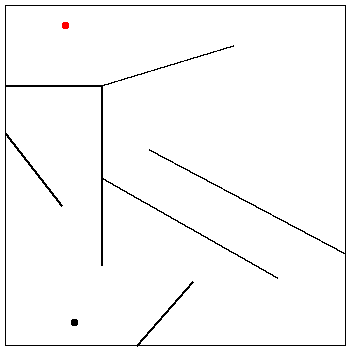

Step 143:


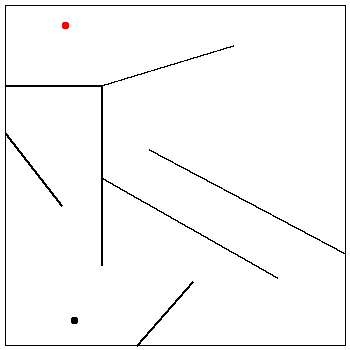

Step 144:


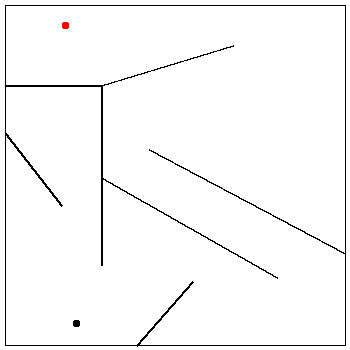

Step 145:


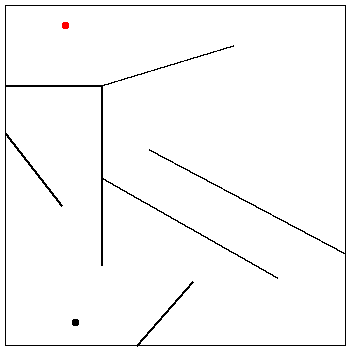

Step 146:


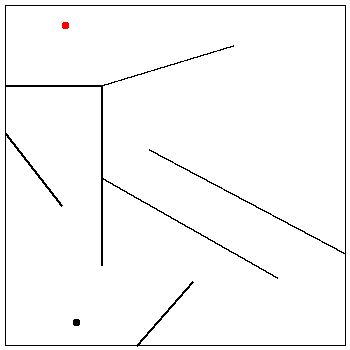

Step 147:


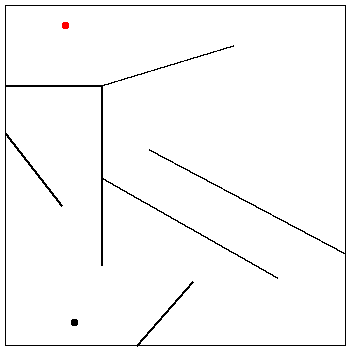

Step 148:


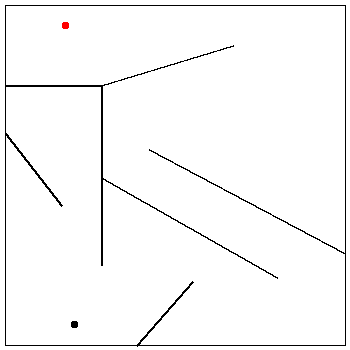

Step 149:


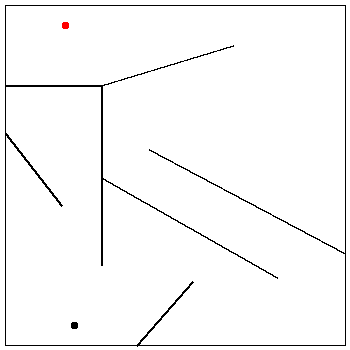

Step 150:


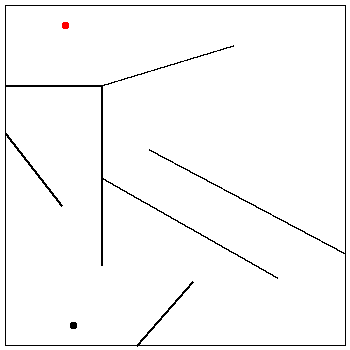

Step 151:


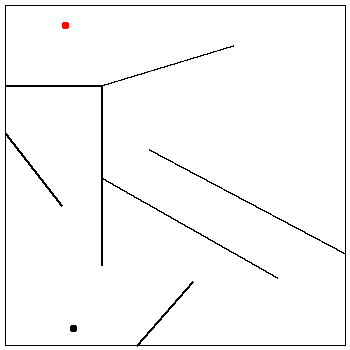

Step 152:


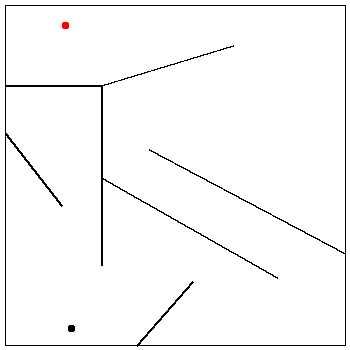

Step 153:


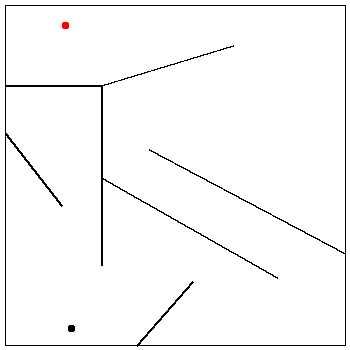

Step 154:


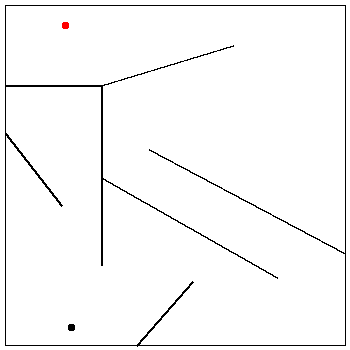

Step 155:


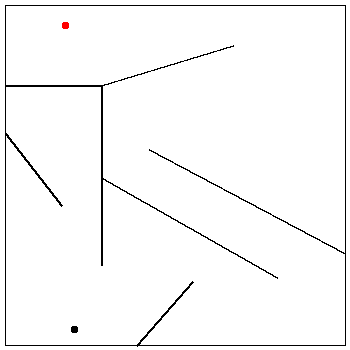

Step 156:


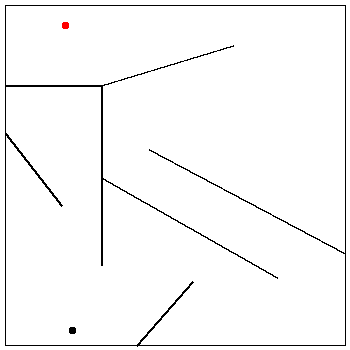

Step 157:


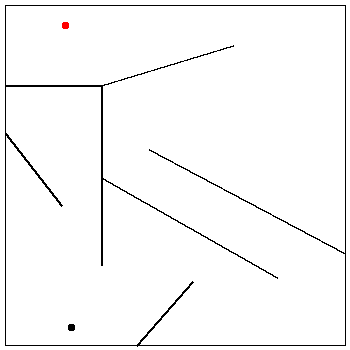

Step 158:


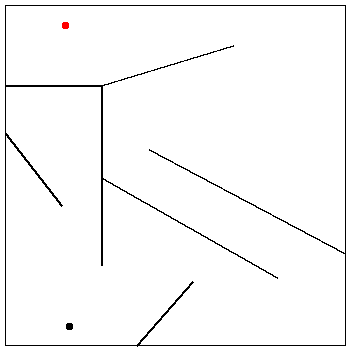

Step 159:


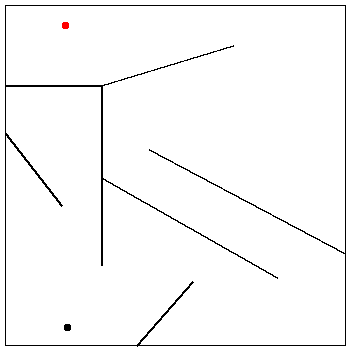

Step 160:


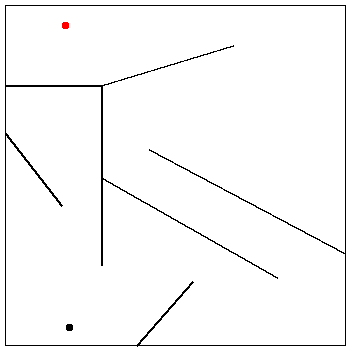

Step 161:


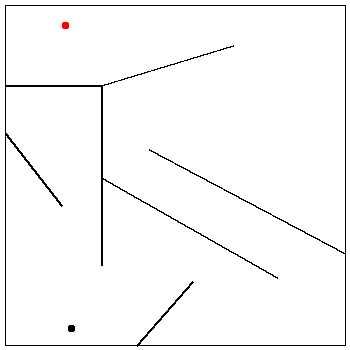

Step 162:


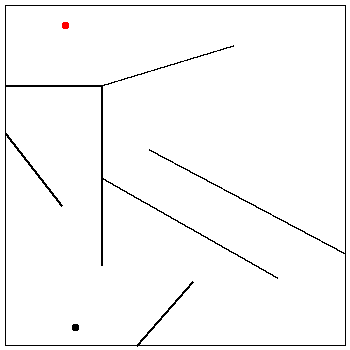

Step 163:


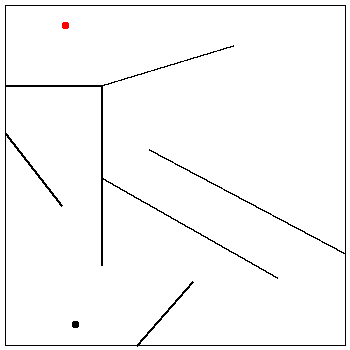

Step 164:


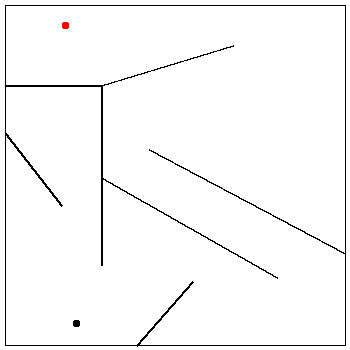

Step 165:


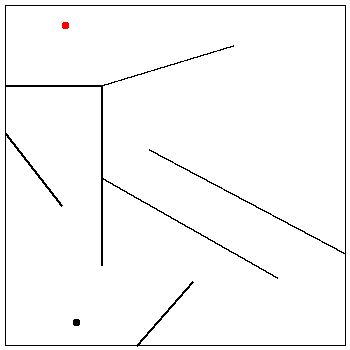

Step 166:


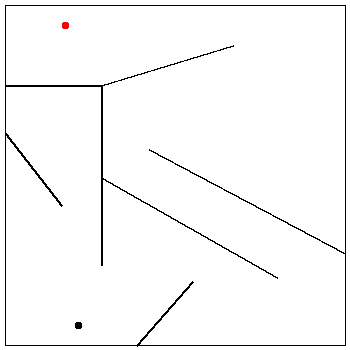

Step 167:


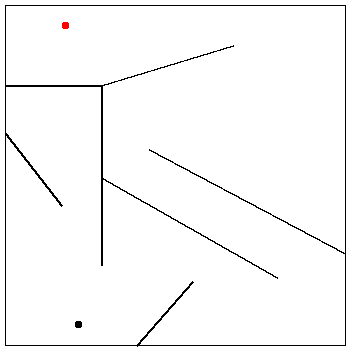

Step 168:


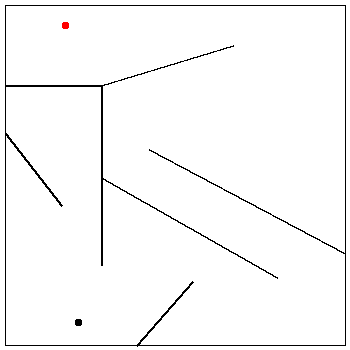

Step 169:


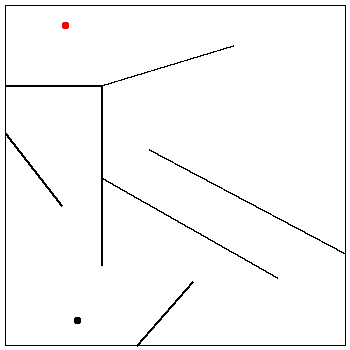

Step 170:


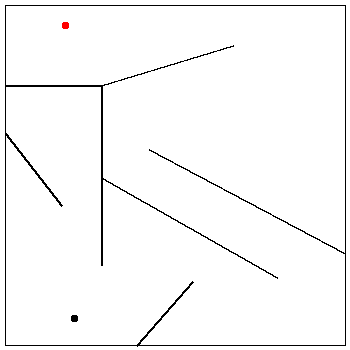

Step 171:


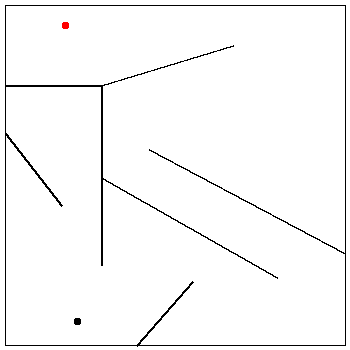

Step 172:


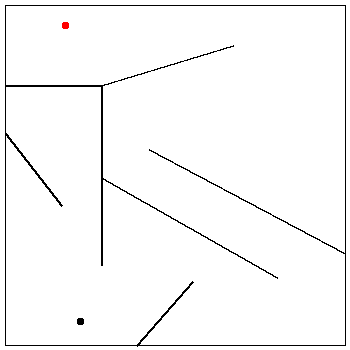

Step 173:


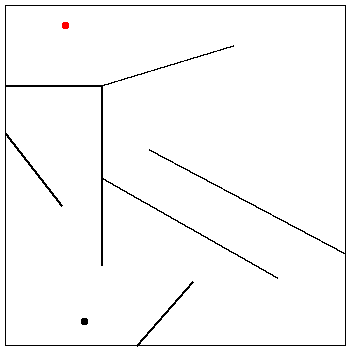

Step 174:


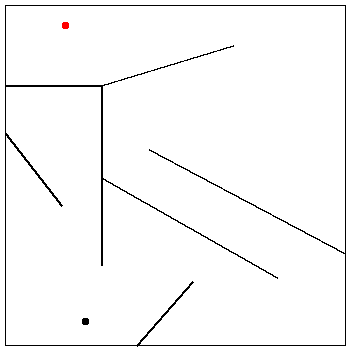

Step 175:


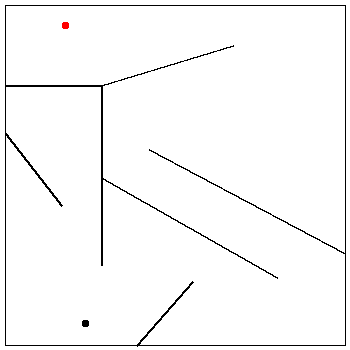

Step 176:


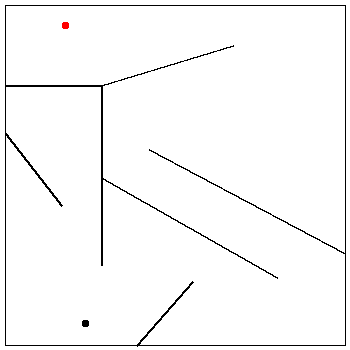

Step 177:


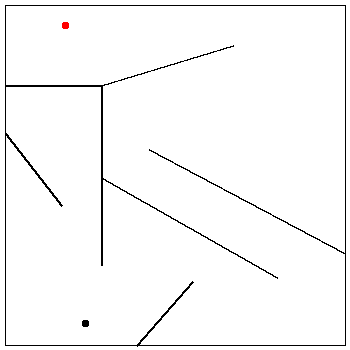

Step 178:


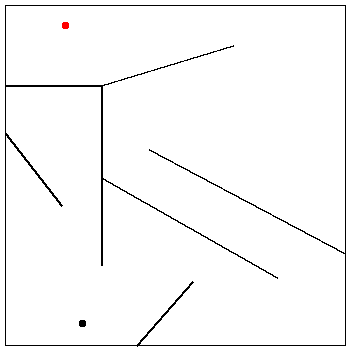

Step 179:


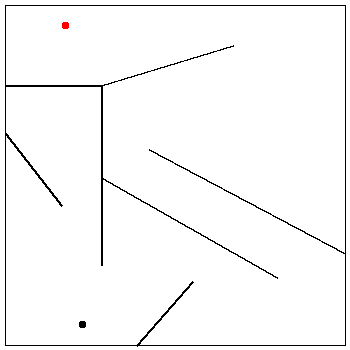

Step 180:


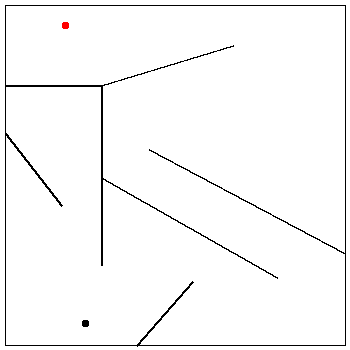

Step 181:


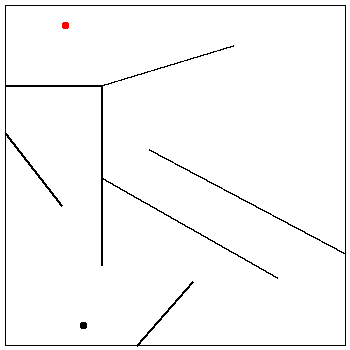

Step 182:


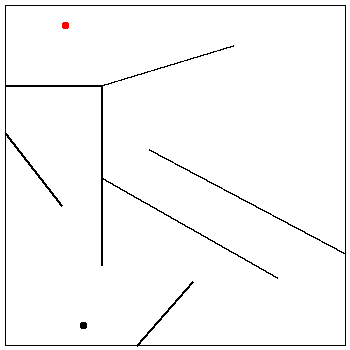

Step 183:


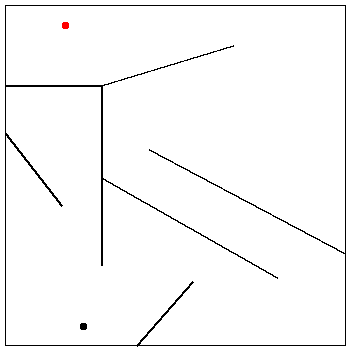

Step 184:


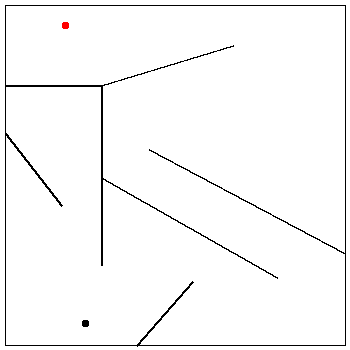

Step 185:


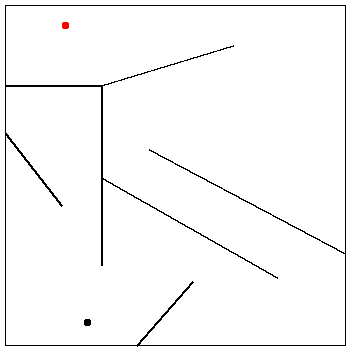

Step 186:


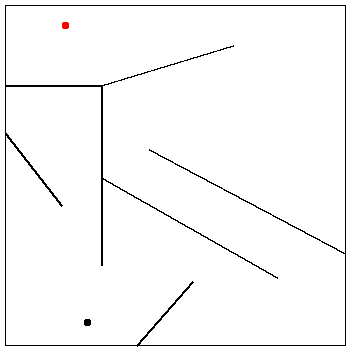

Step 187:


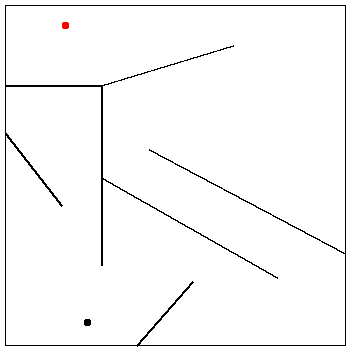

Step 188:


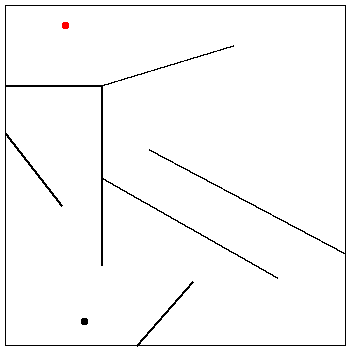

Step 189:


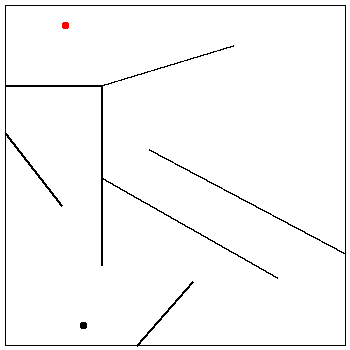

Step 190:


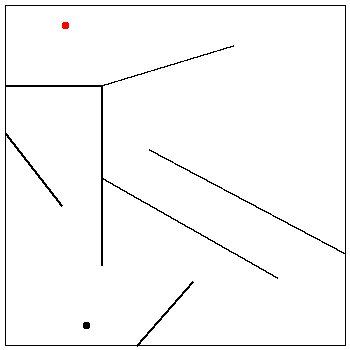

Step 191:


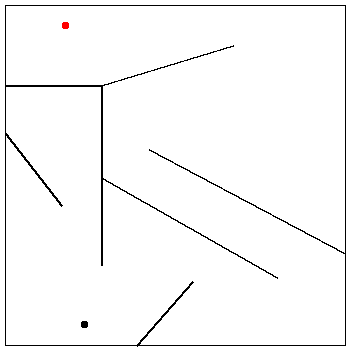

Step 192:


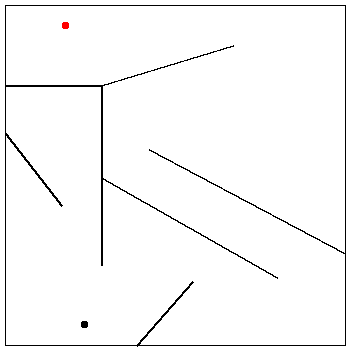

Step 193:


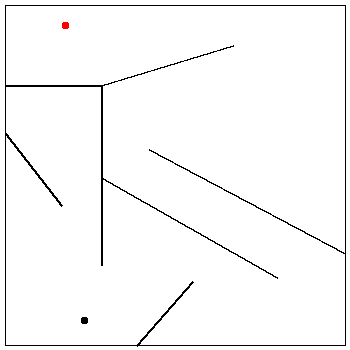

Step 194:


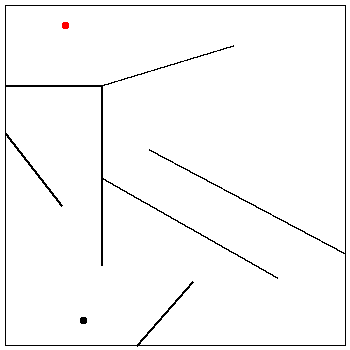

Step 195:


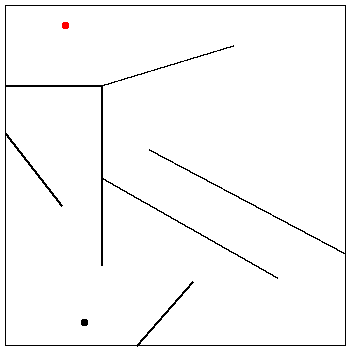

Step 196:


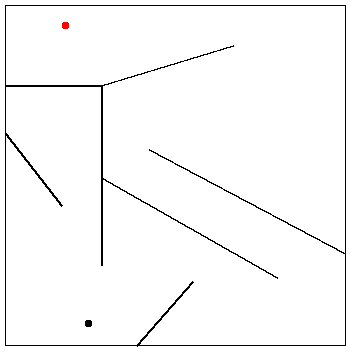

Step 197:


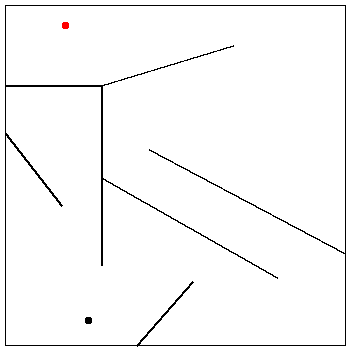

Step 198:


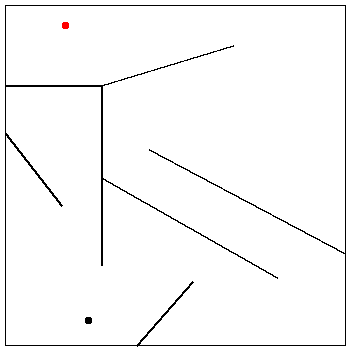

Step 199:


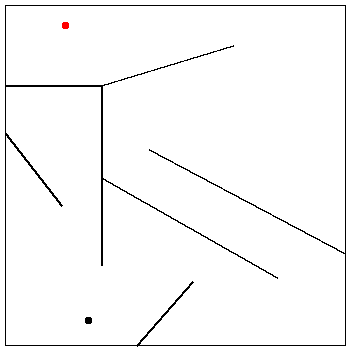

Step 200:


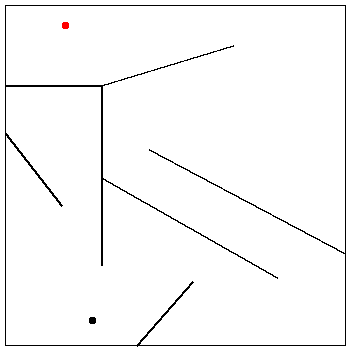

Step 201:


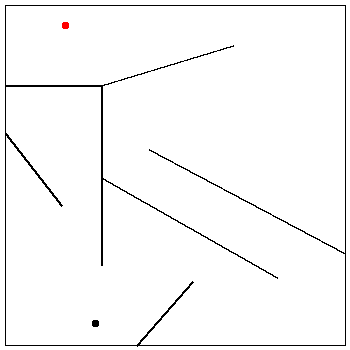

Step 202:


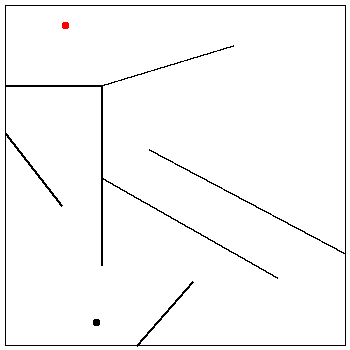

Step 203:


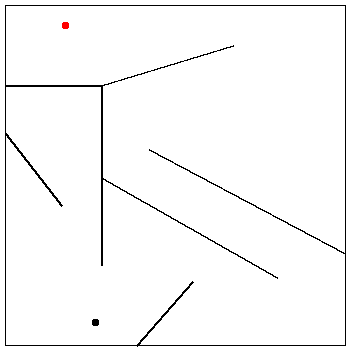

Step 204:


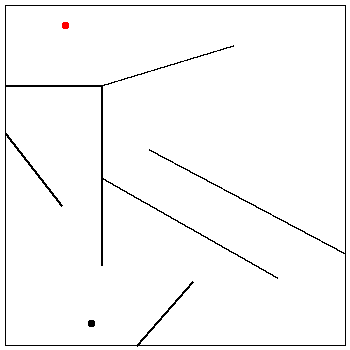

Step 205:


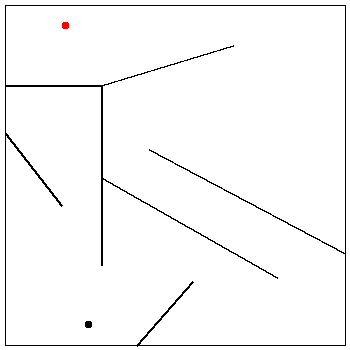

Step 206:


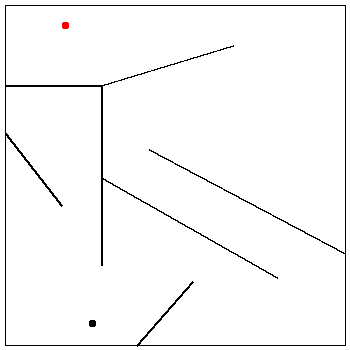

Step 207:


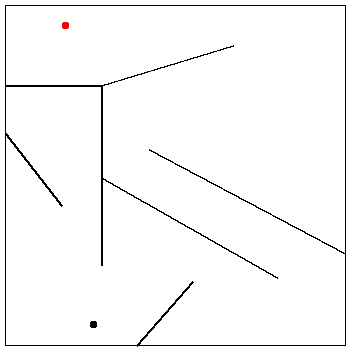

Step 208:


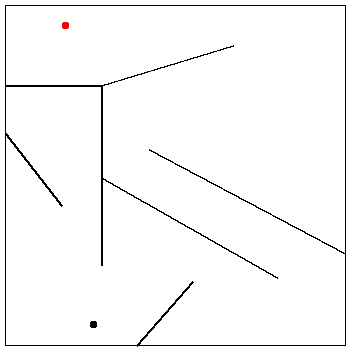

Step 209:


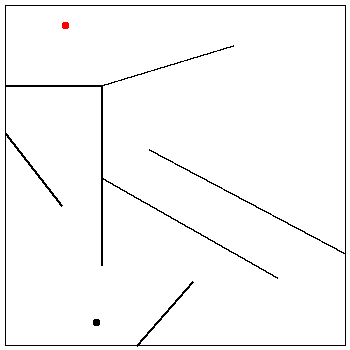

Step 210:


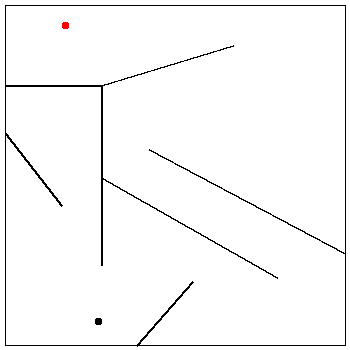

Step 211:


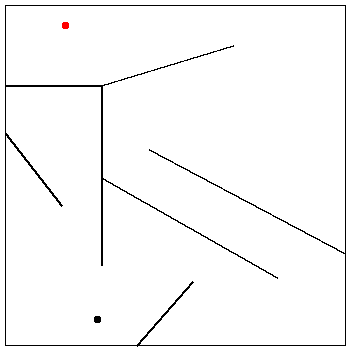

Step 212:


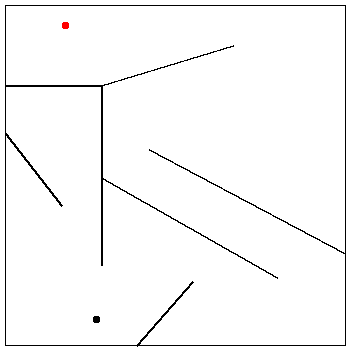

Step 213:


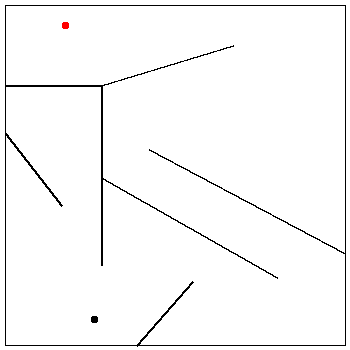

Step 214:


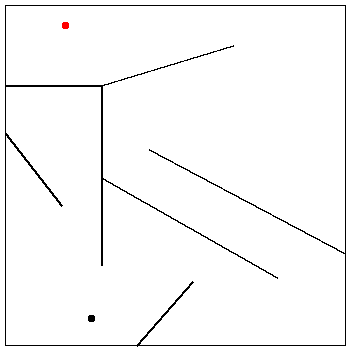

Step 215:


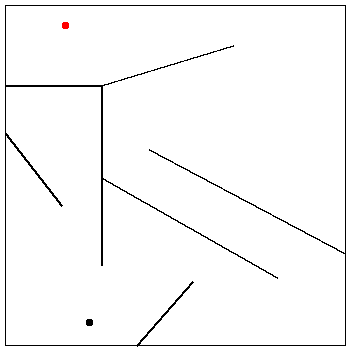

Step 216:


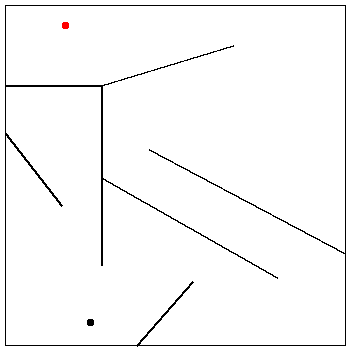

Step 217:


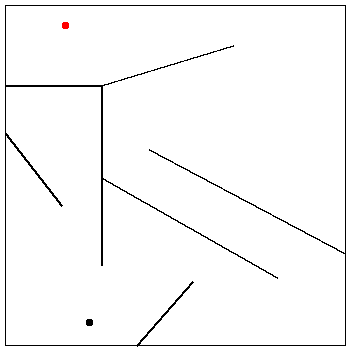

Step 218:


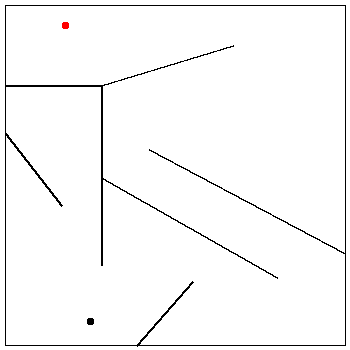

Step 219:


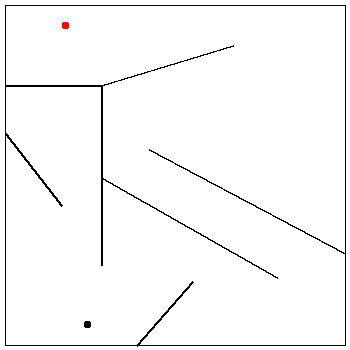

Step 220:


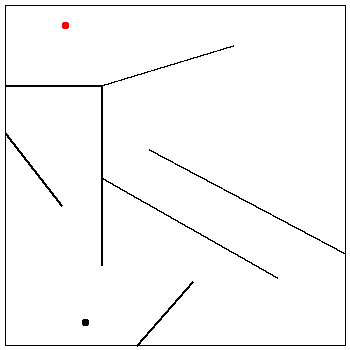

Step 221:


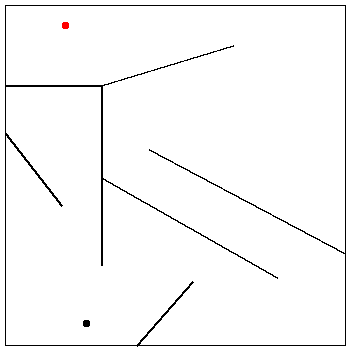

Step 222:


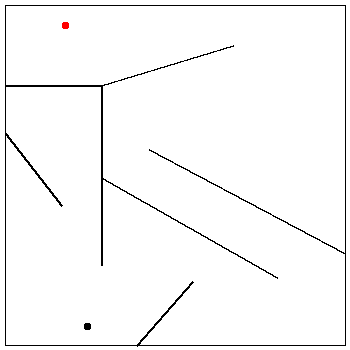

Step 223:


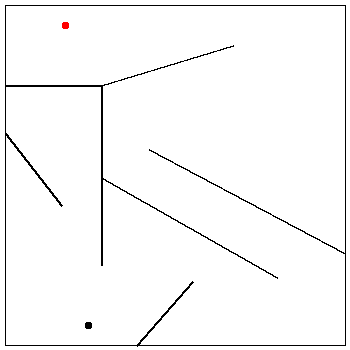

Step 224:


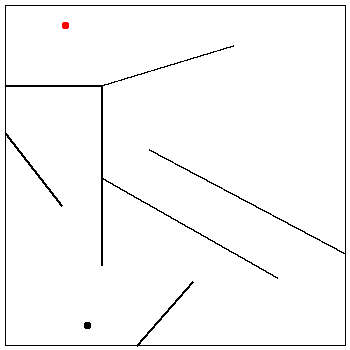

Step 225:


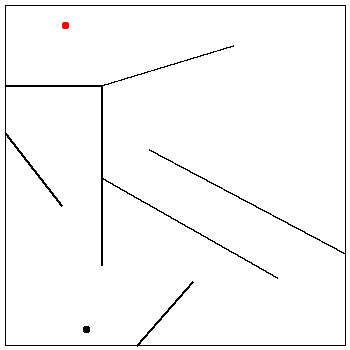

Step 226:


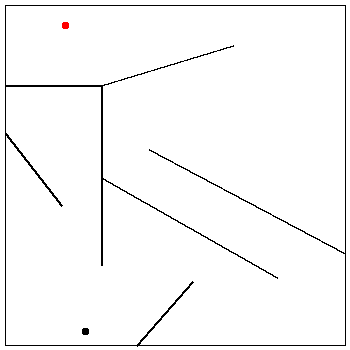

Step 227:


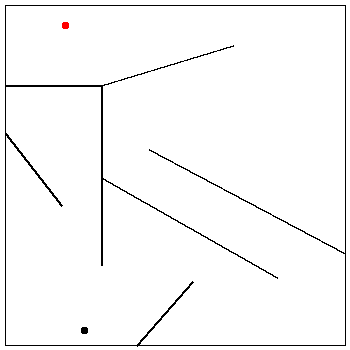

Step 228:


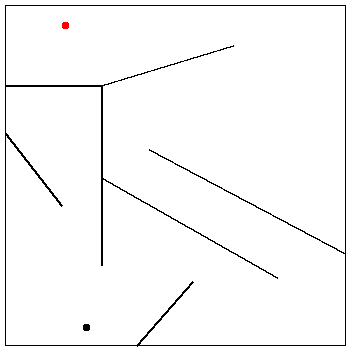

Step 229:


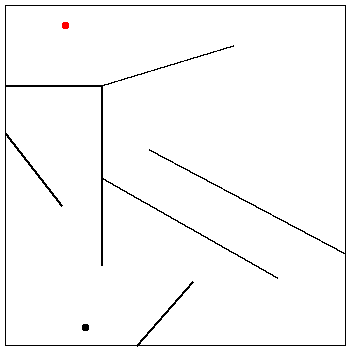

Step 230:


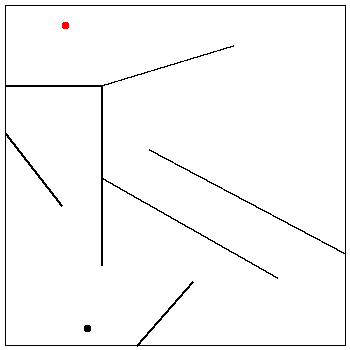

Step 231:


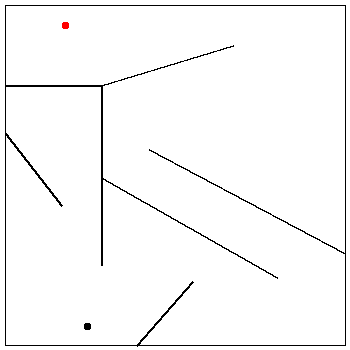

Step 232:


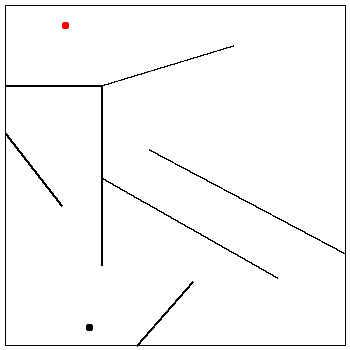

Step 233:


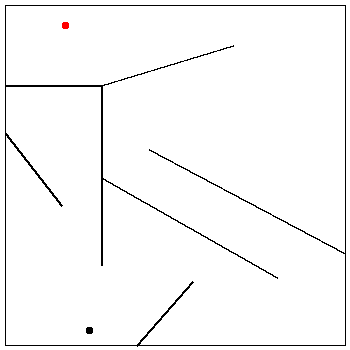

Step 234:


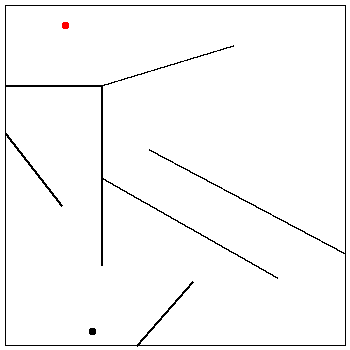

Step 235:


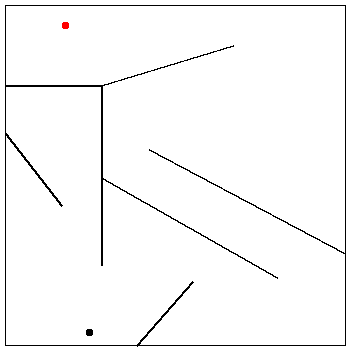

Step 236:


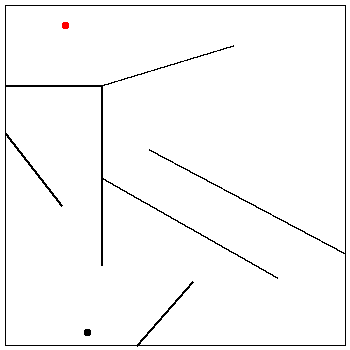

Step 237:


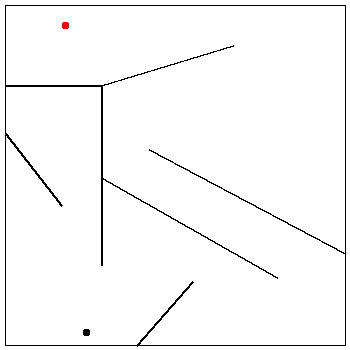

Step 238:


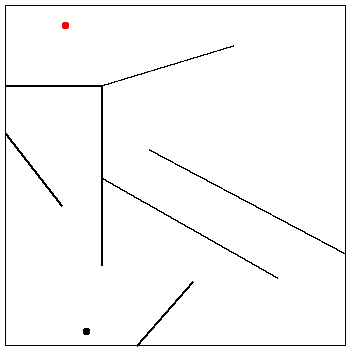

Step 239:


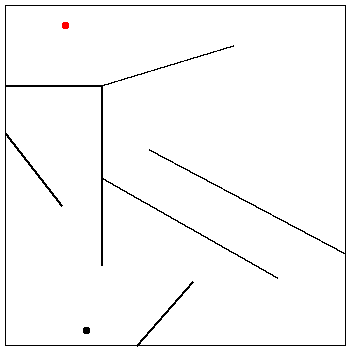

Step 240:


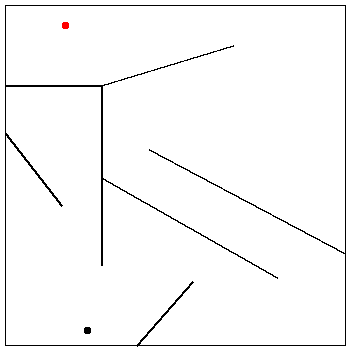

Step 241:


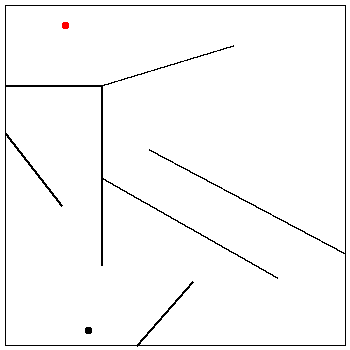

Step 242:


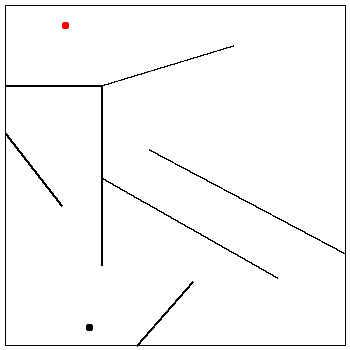

Step 243:


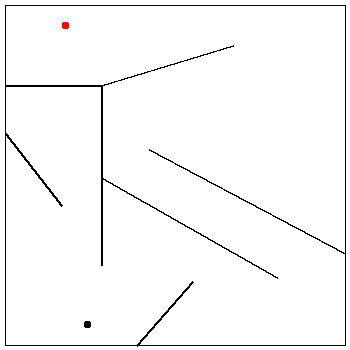

Step 244:


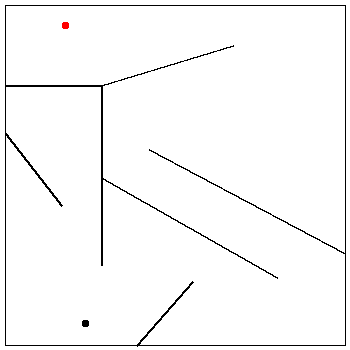

Step 245:


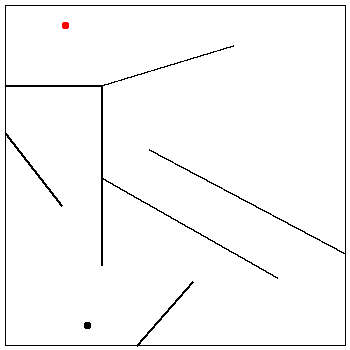

Step 246:


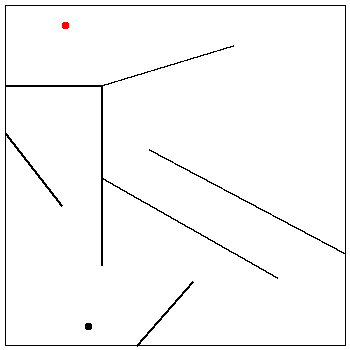

Step 247:


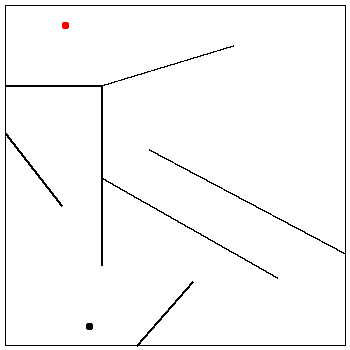

Step 248:


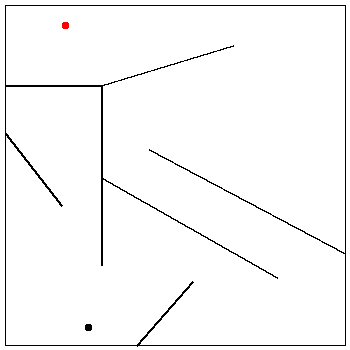

Step 249:


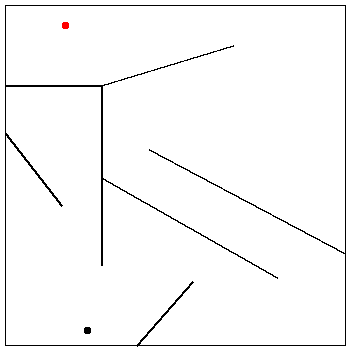

Step 250:


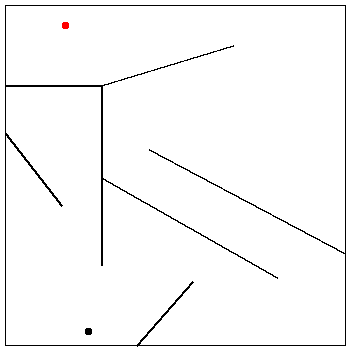

Step 251:


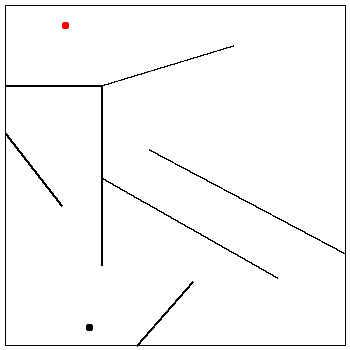

Step 252:


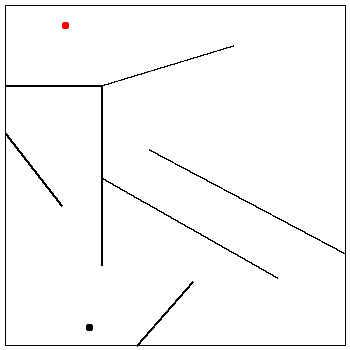

Step 253:


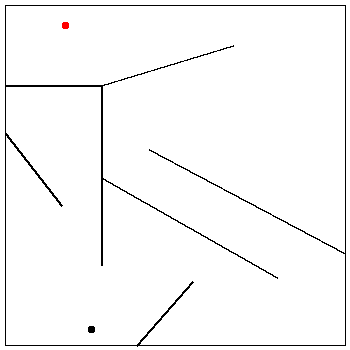

Step 254:


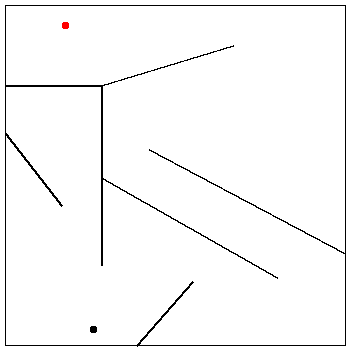

Step 255:


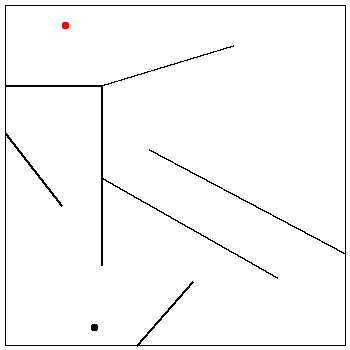

Step 256:


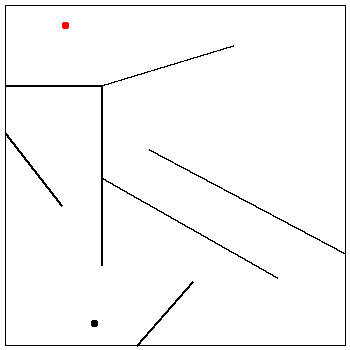

Step 257:


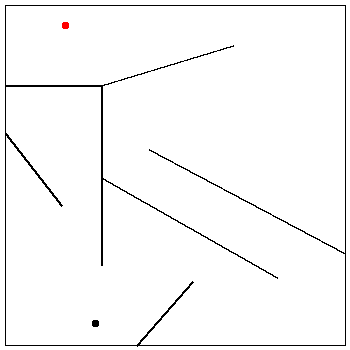

Step 258:


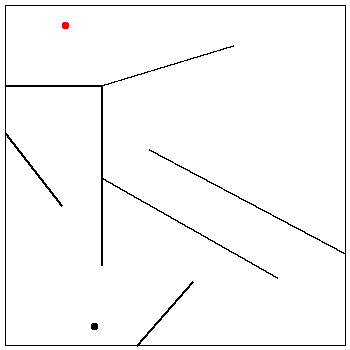

Step 259:


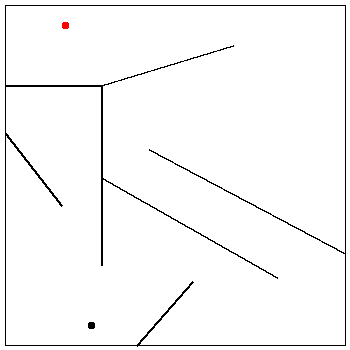

Step 260:


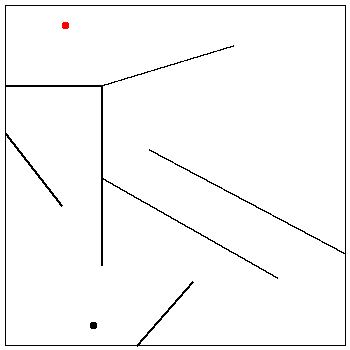

Step 261:


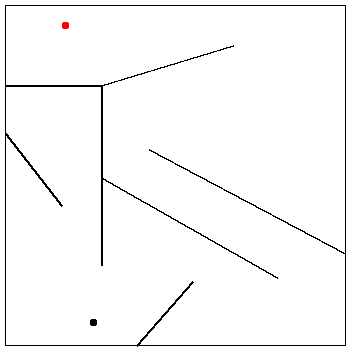

Step 262:


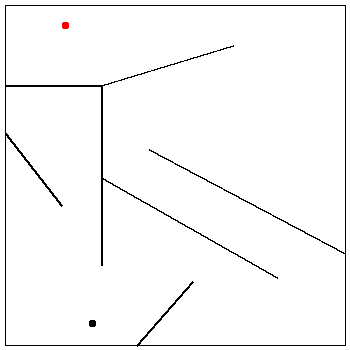

Step 263:


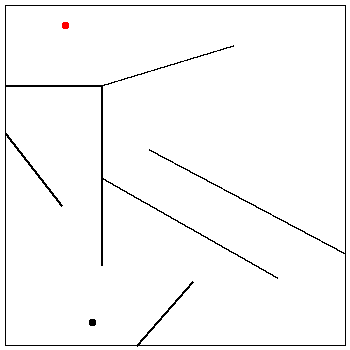

Step 264:


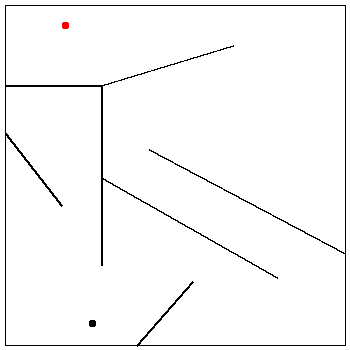

Step 265:


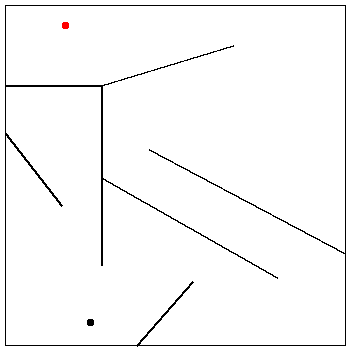

Step 266:


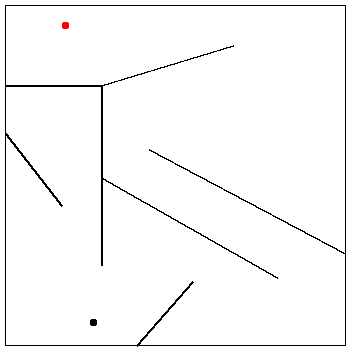

Step 267:


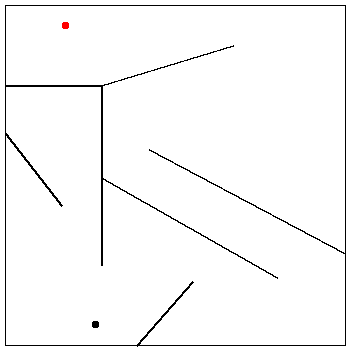

Step 268:


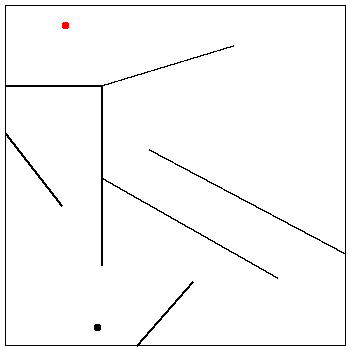

Step 269:


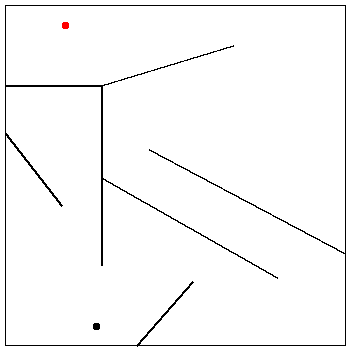

Step 270:


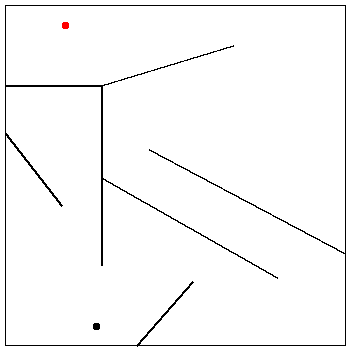

Step 271:


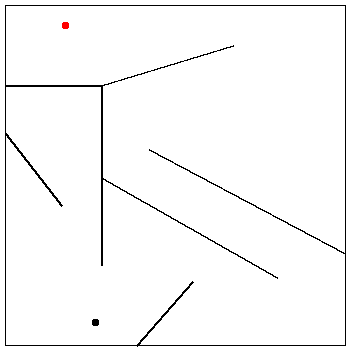

Step 272:


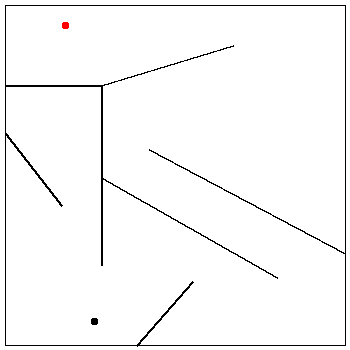

Step 273:


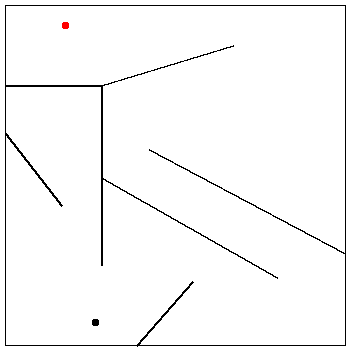

Step 274:


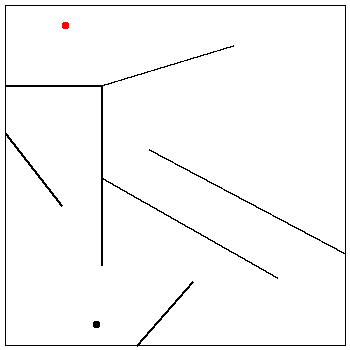

Step 275:


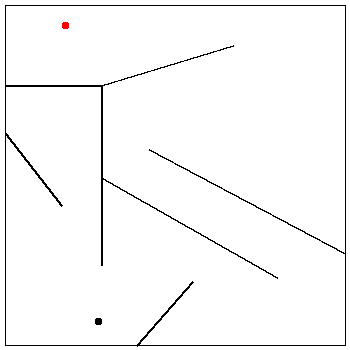

Step 276:


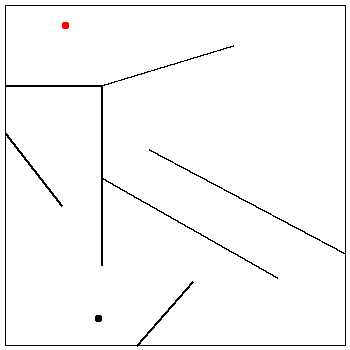

Step 277:


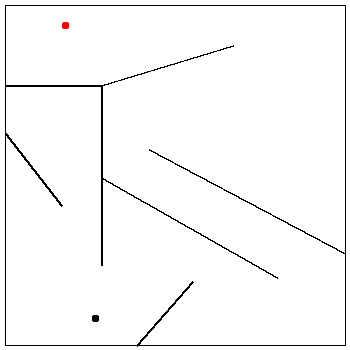

Step 278:


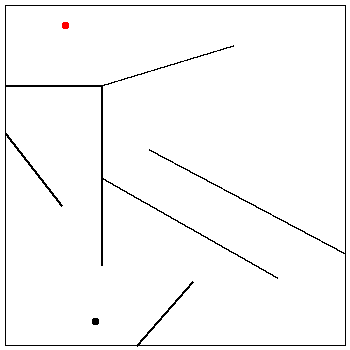

Step 279:


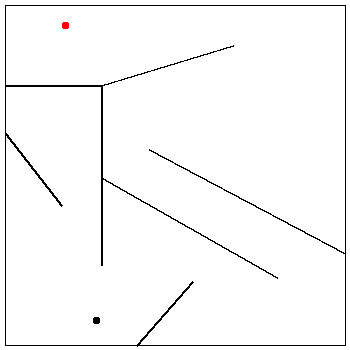

Step 280:


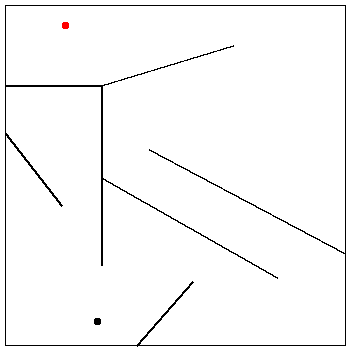

Step 281:


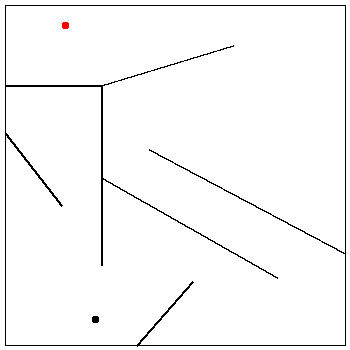

Step 282:


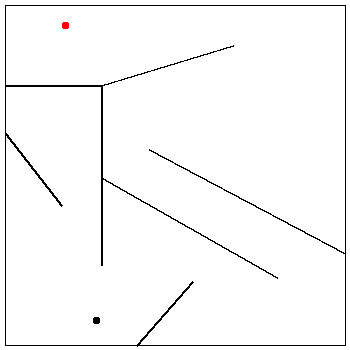

Step 283:


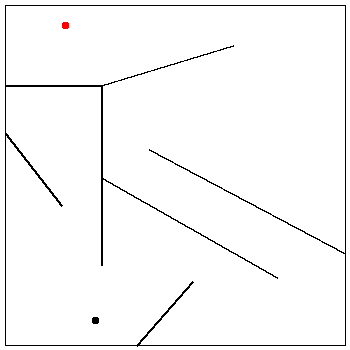

Step 284:


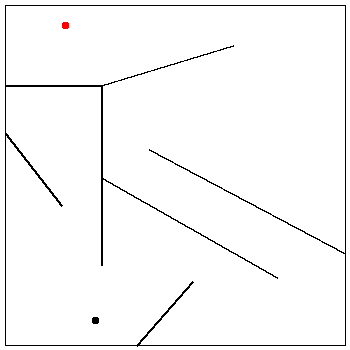

Step 285:


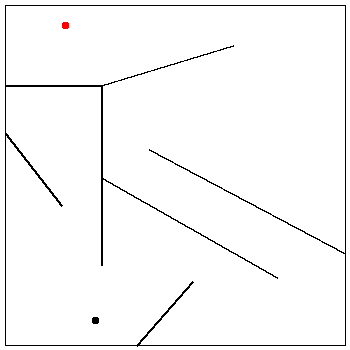

Step 286:


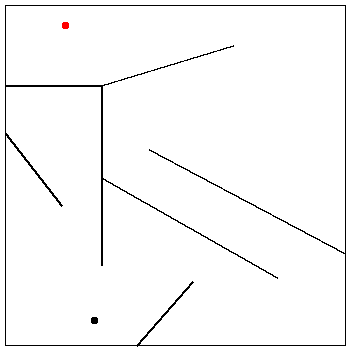

Step 287:


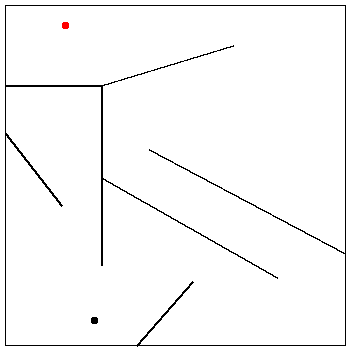

Step 288:


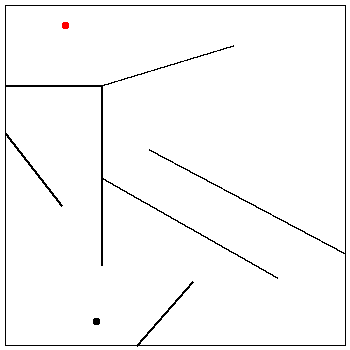

Step 289:


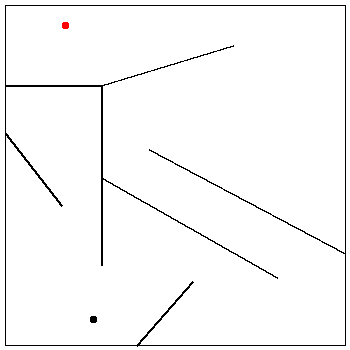

Step 290:


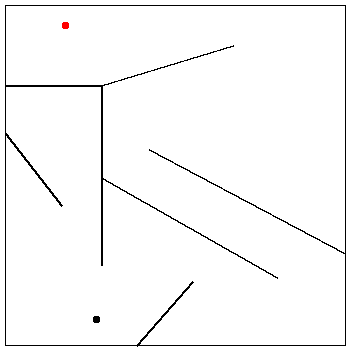

Step 291:


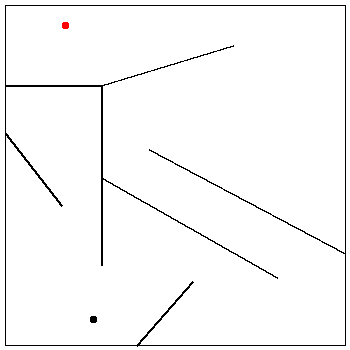

Step 292:


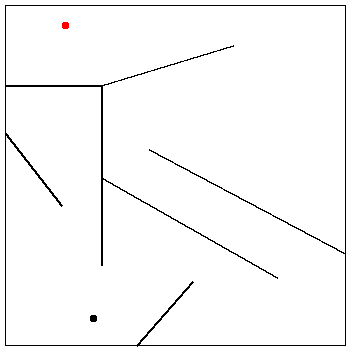

Step 293:


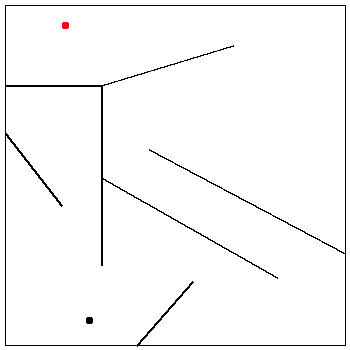

Step 294:


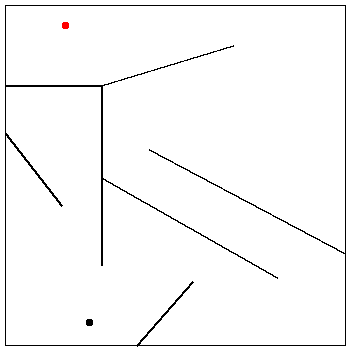

Step 295:


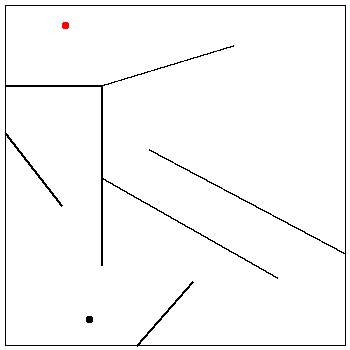

Step 296:


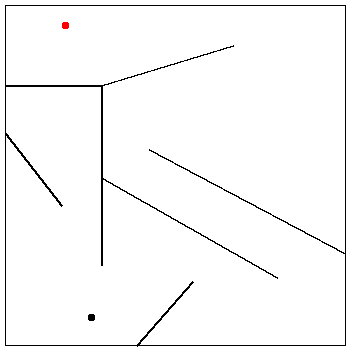

Step 297:


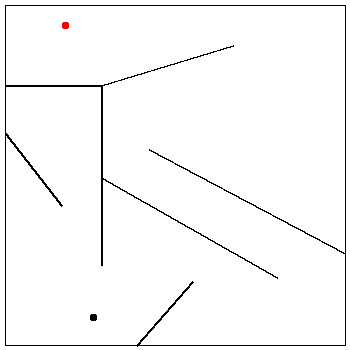

Step 298:


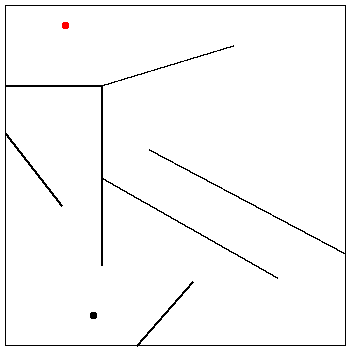

Step 299:


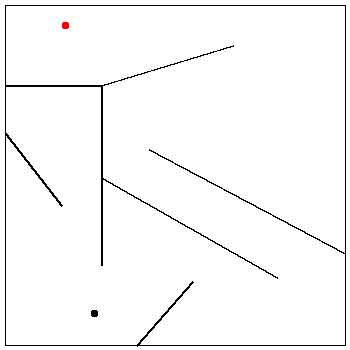

Step 300:


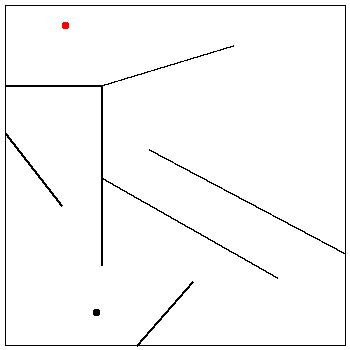

Step 301:


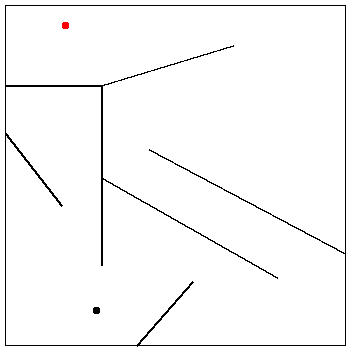

Step 302:


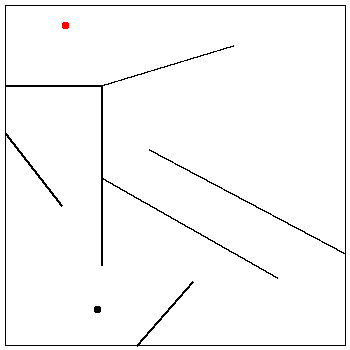

Step 303:


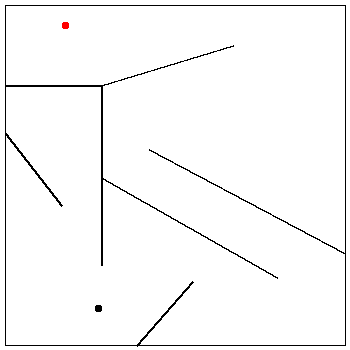

Step 304:


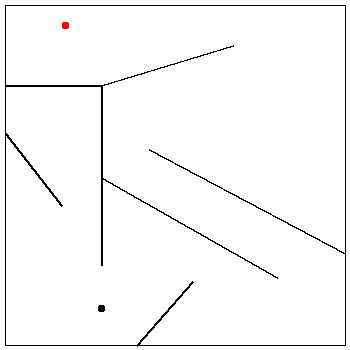

Step 305:


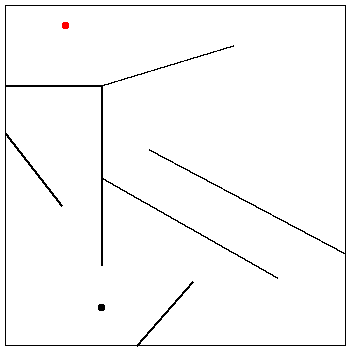

Step 306:


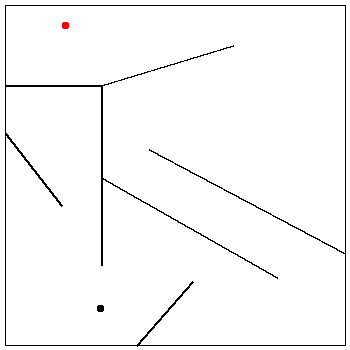

Step 307:


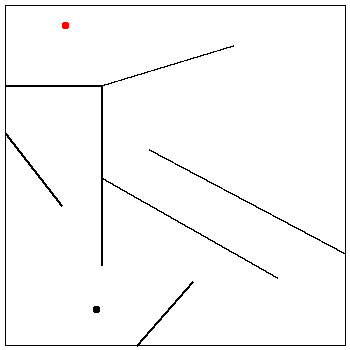

Step 308:


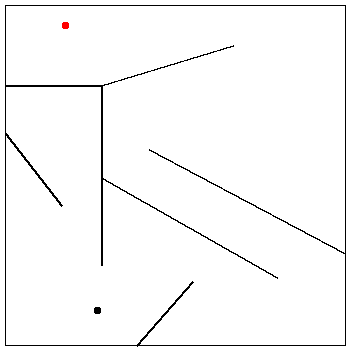

Step 309:


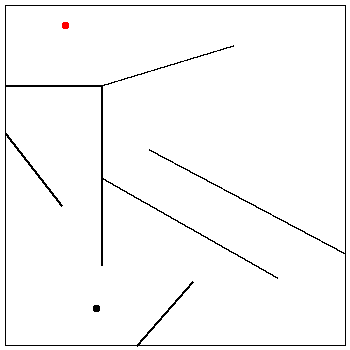

Step 310:


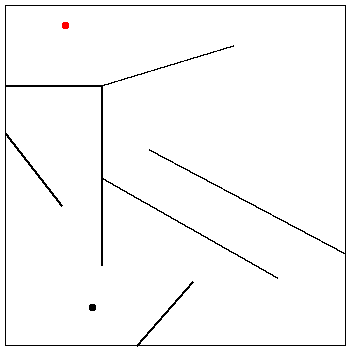

Step 311:


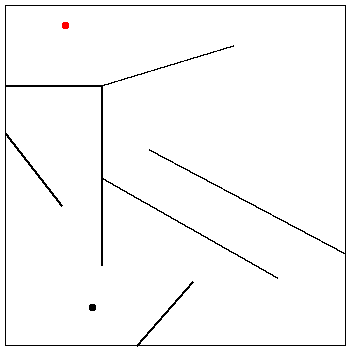

Step 312:


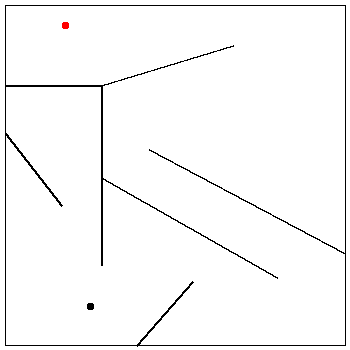

Step 313:


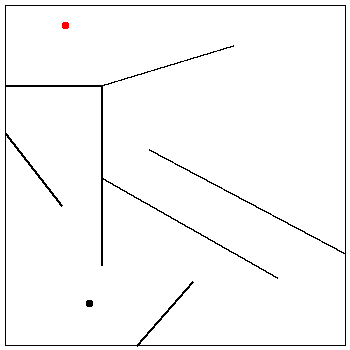

Step 314:


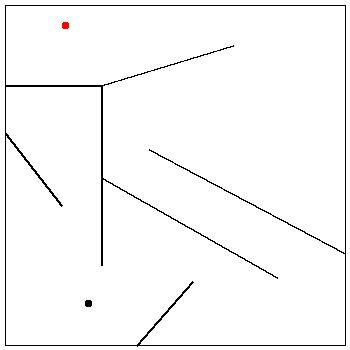

Step 315:


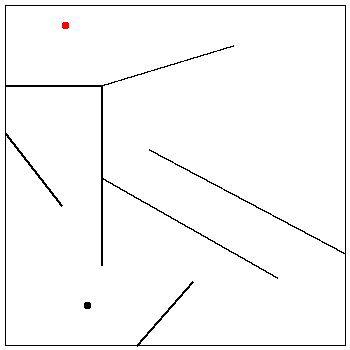

Step 316:


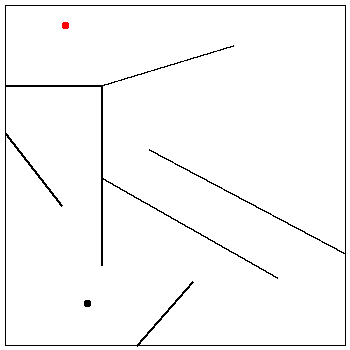

Step 317:


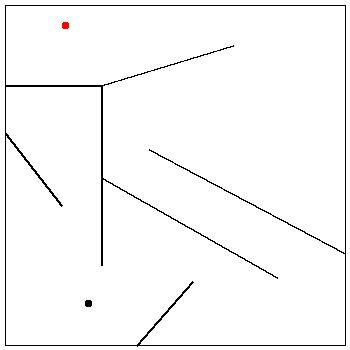

Step 318:


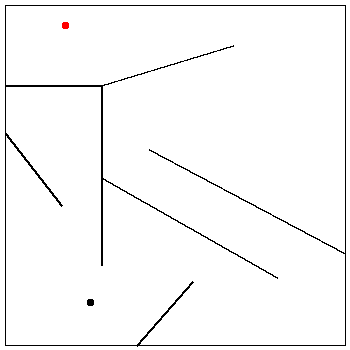

Step 319:


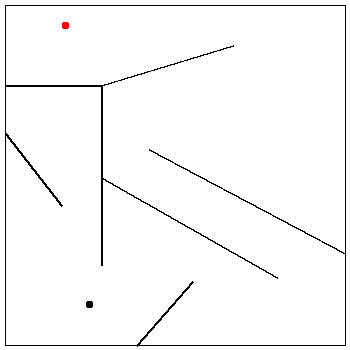

Step 320:


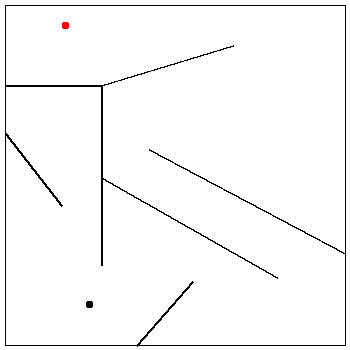

Step 321:


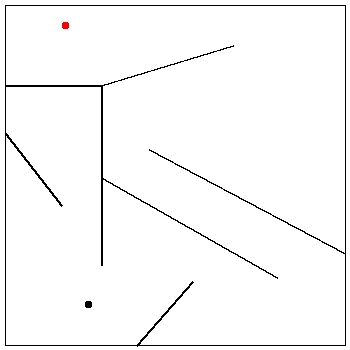

Step 322:


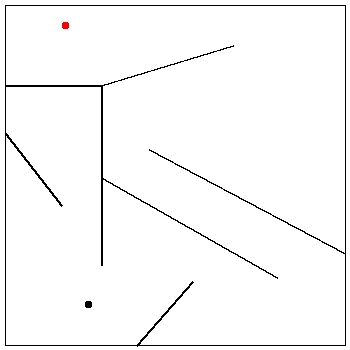

Step 323:


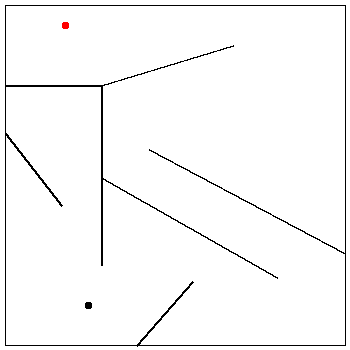

Step 324:


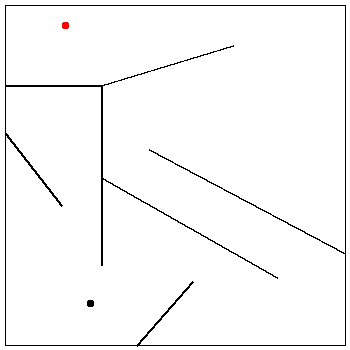

Step 325:


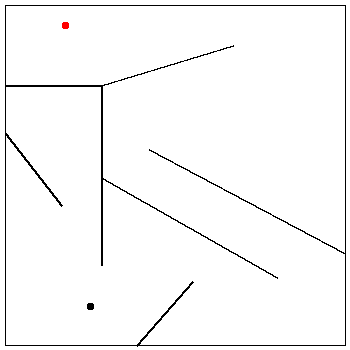

Step 326:


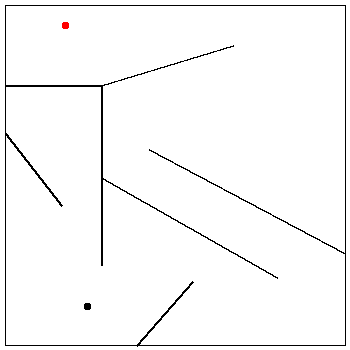

Step 327:


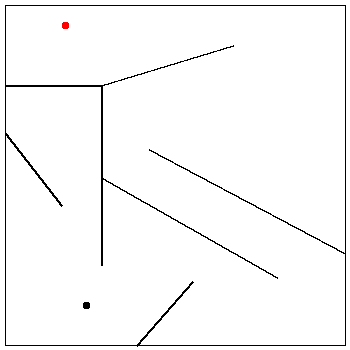

Step 328:


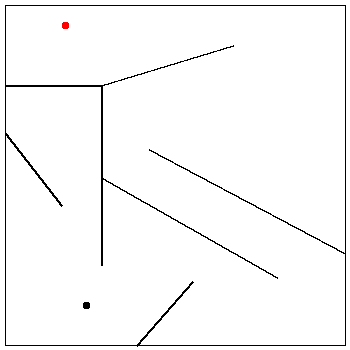

Step 329:


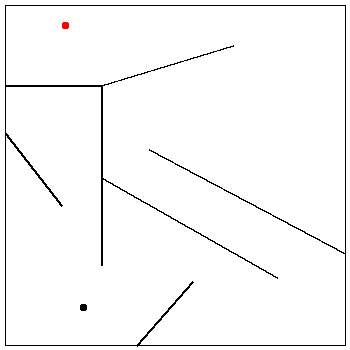

Step 330:


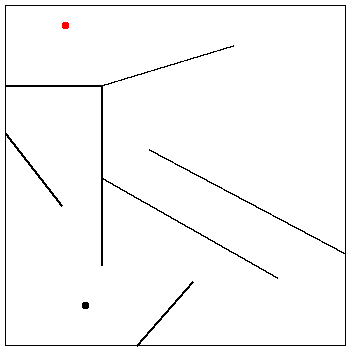

Step 331:


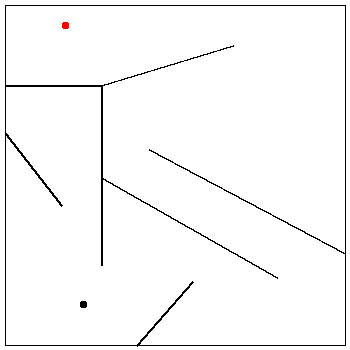

Step 332:


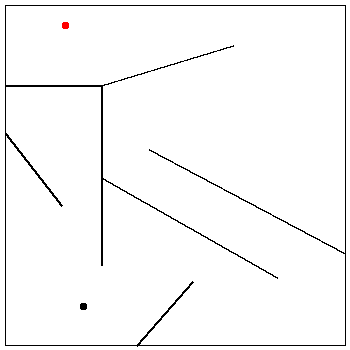

Step 333:


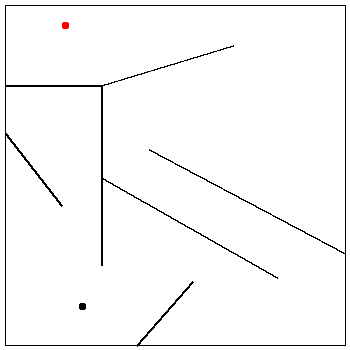

Step 334:


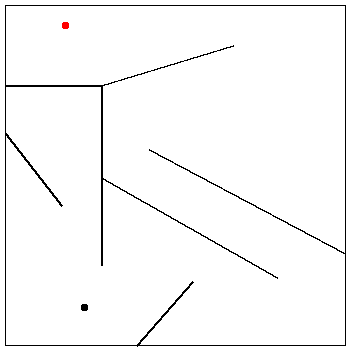

Step 335:


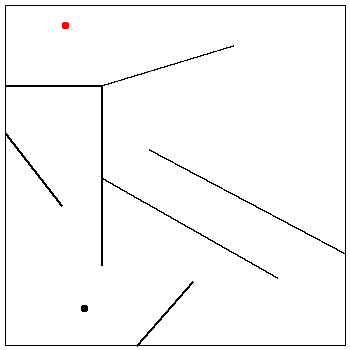

Step 336:


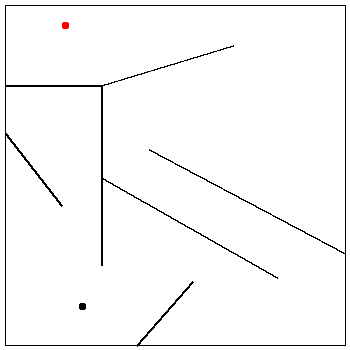

Step 337:


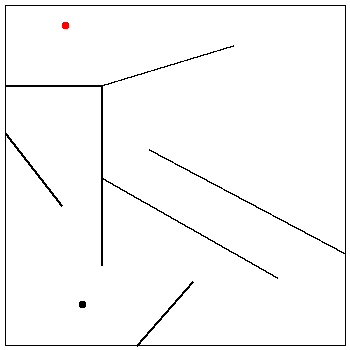

Step 338:


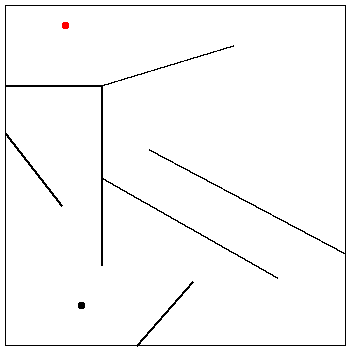

Step 339:


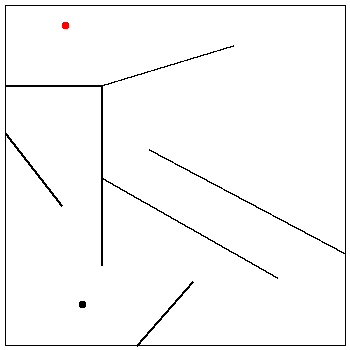

Step 340:


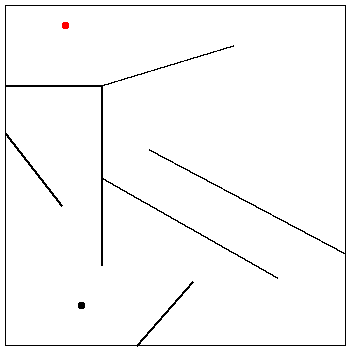

Step 341:


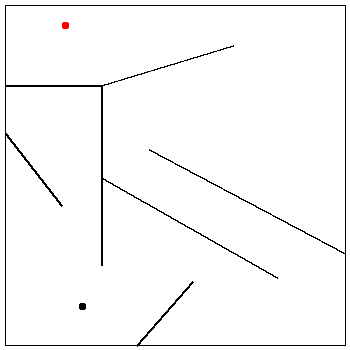

Step 342:


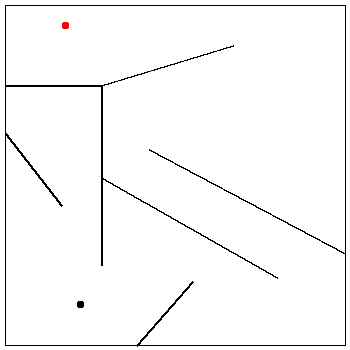

Step 343:


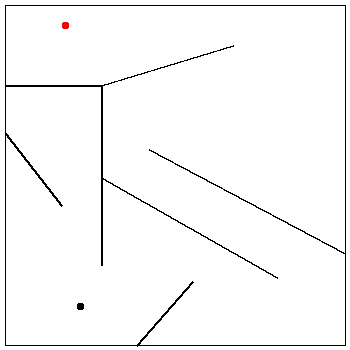

Step 344:


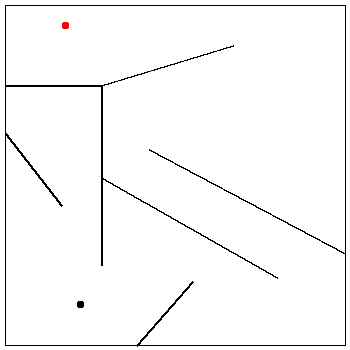

Step 345:


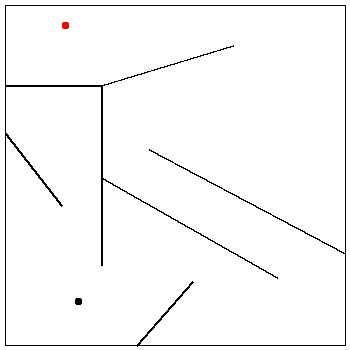

Step 346:


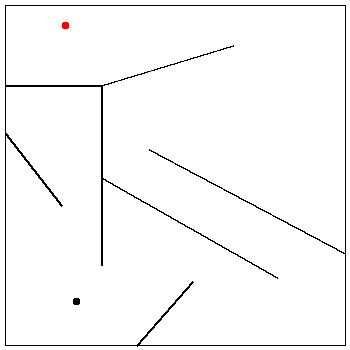

Step 347:


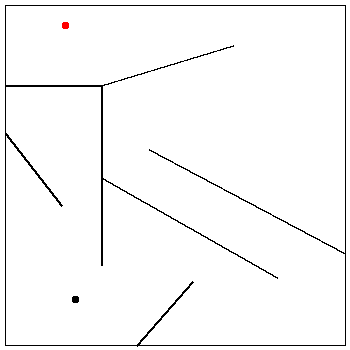

Step 348:


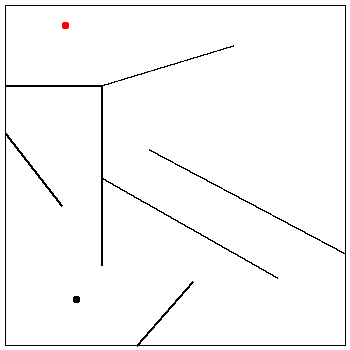

Step 349:


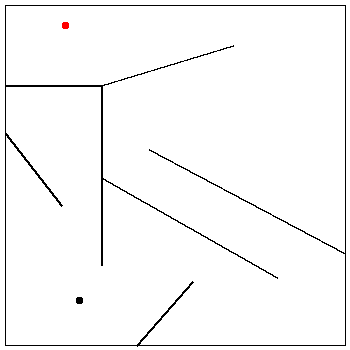

Step 350:


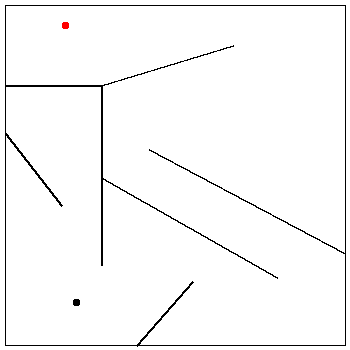

Step 351:


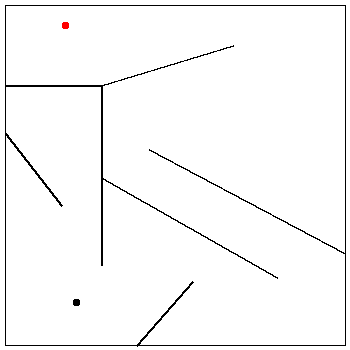

Step 352:


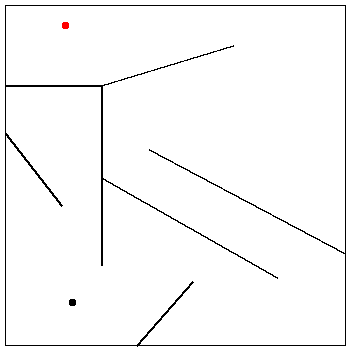

Step 353:


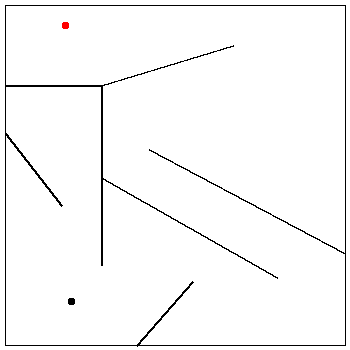

Step 354:


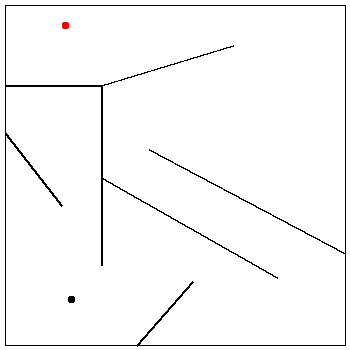

Step 355:


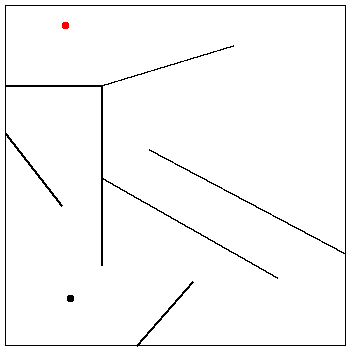

Step 356:


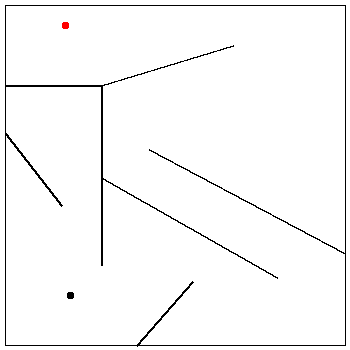

Step 357:


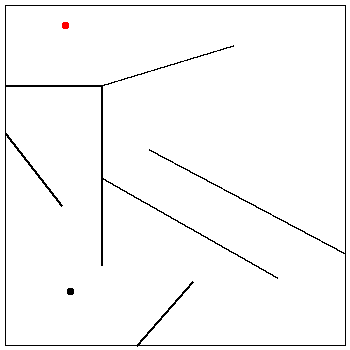

Step 358:


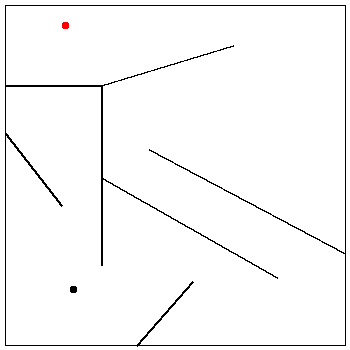

Step 359:


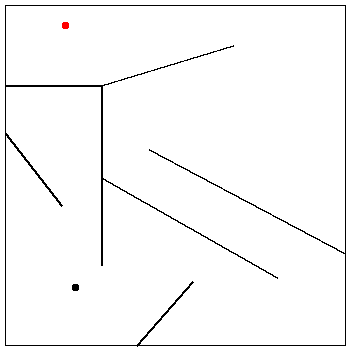

Step 360:


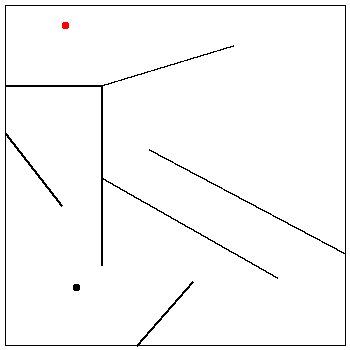

Step 361:


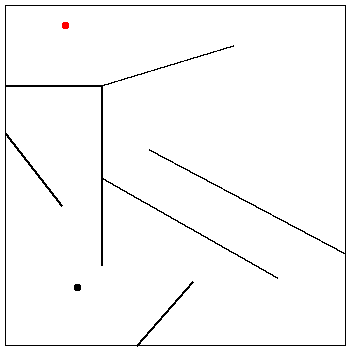

Step 362:


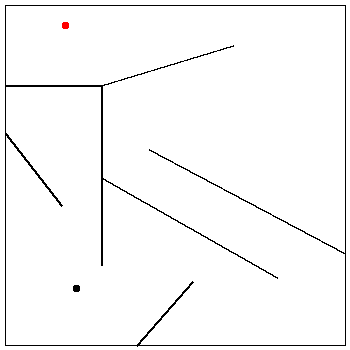

Step 363:


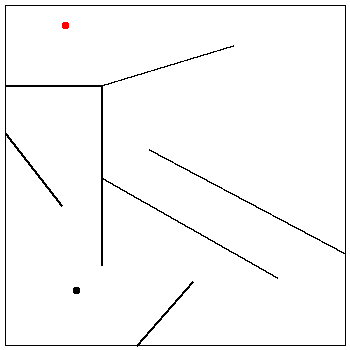

Step 364:


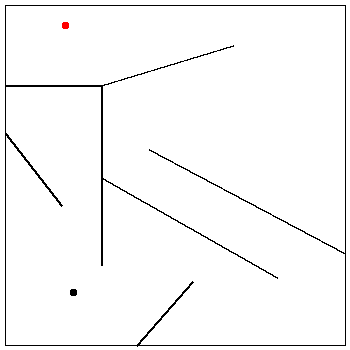

Step 365:


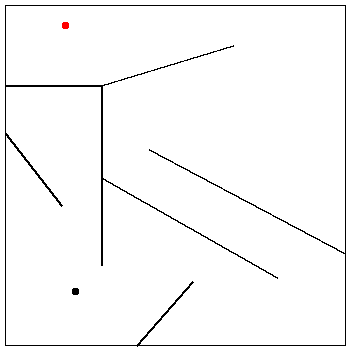

Step 366:


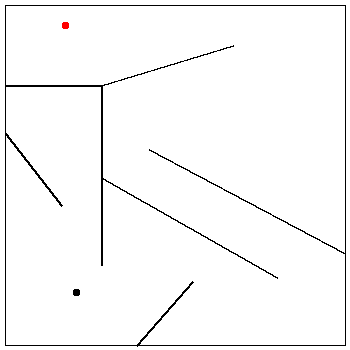

Step 367:


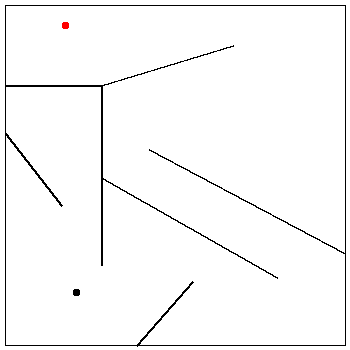

Step 368:


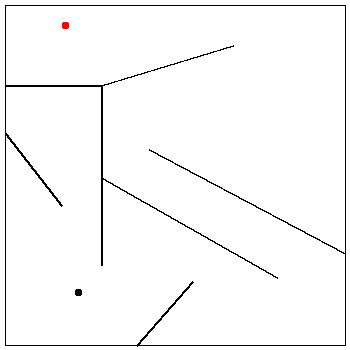

Step 369:


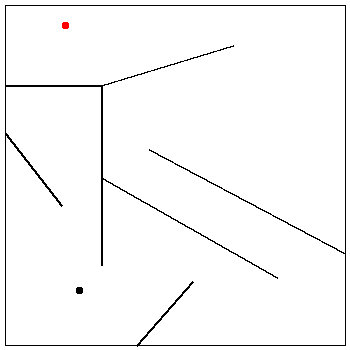

Step 370:


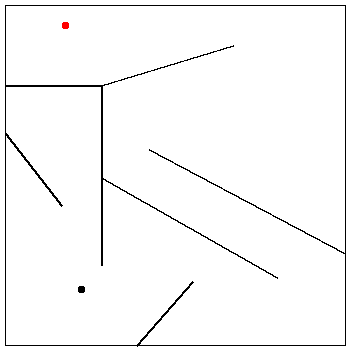

Step 371:


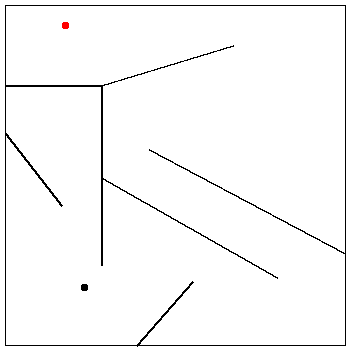

Step 372:


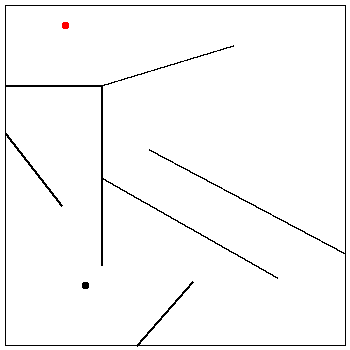

Step 373:


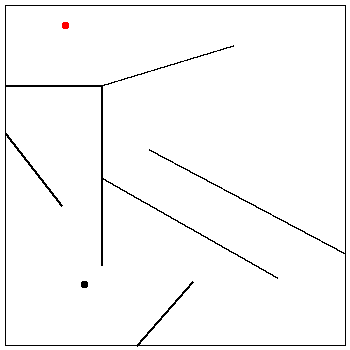

Step 374:


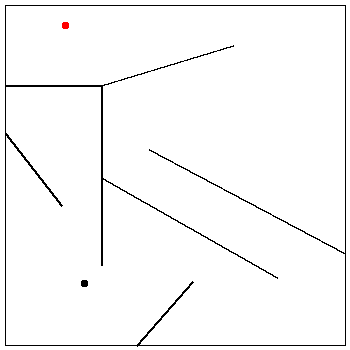

Step 375:


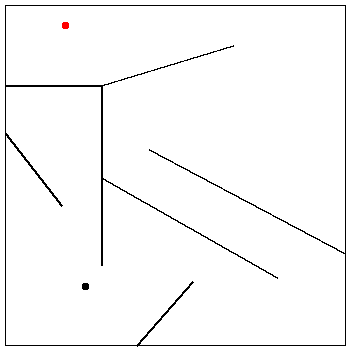

Step 376:


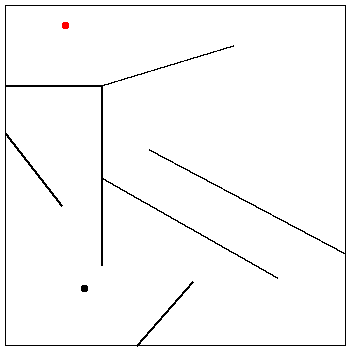

Step 377:


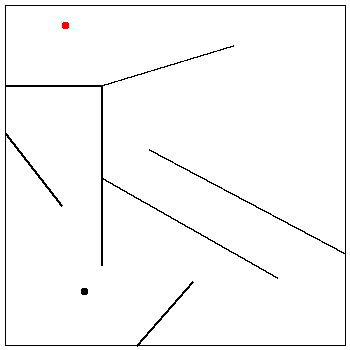

Step 378:


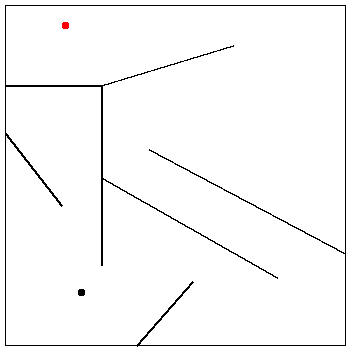

Step 379:


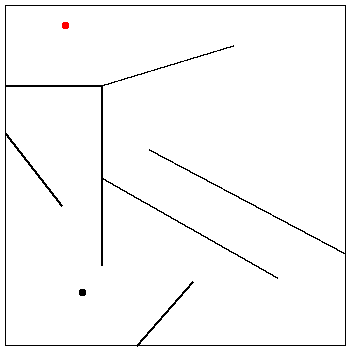

Step 380:


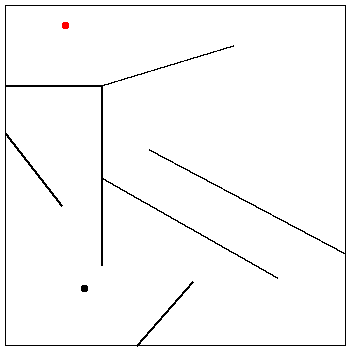

Step 381:


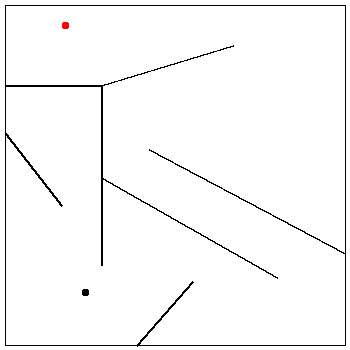

Step 382:


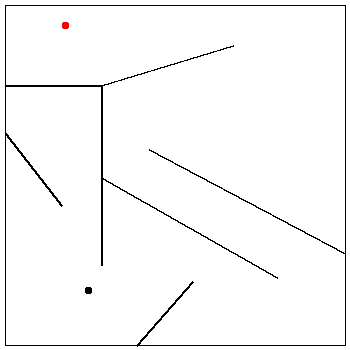

Step 383:


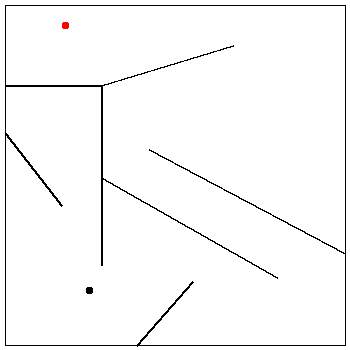

Step 384:


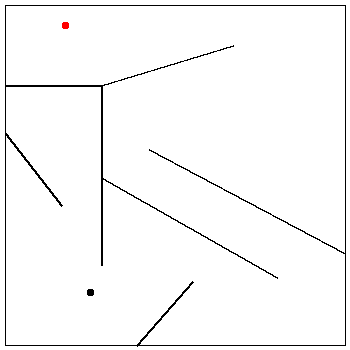

Step 385:


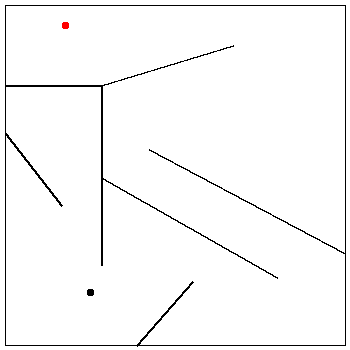

Step 386:


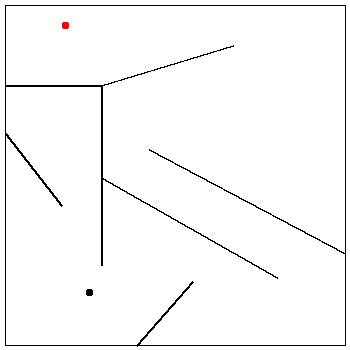

Step 387:


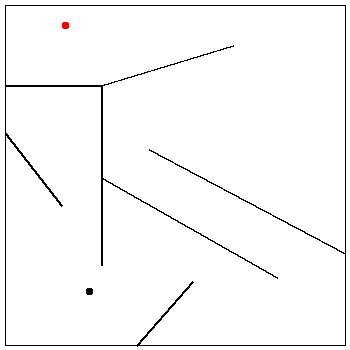

Step 388:


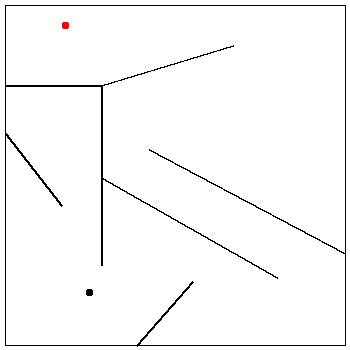

Step 389:


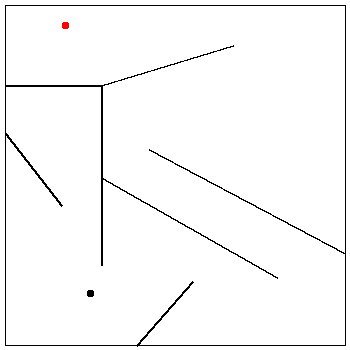

Step 390:


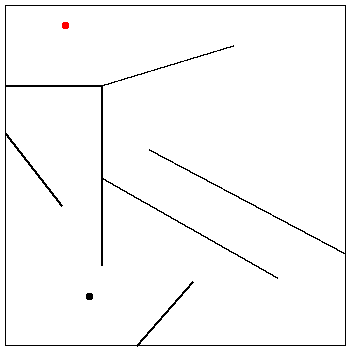

Step 391:


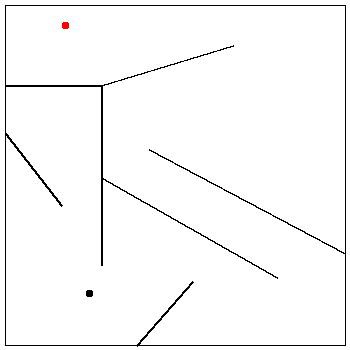

Step 392:


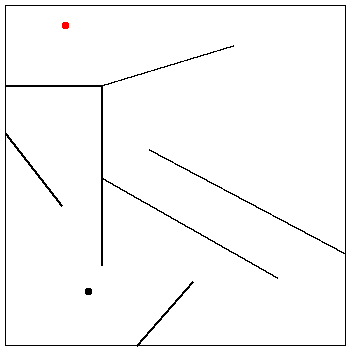

Step 393:


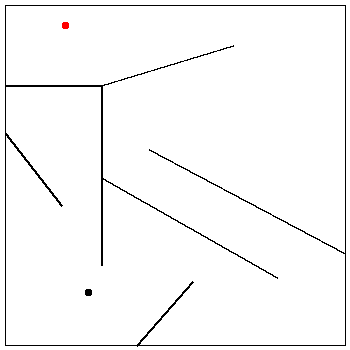

Step 394:


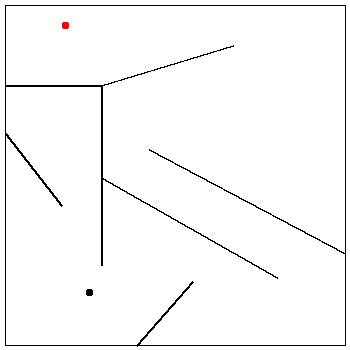

Step 395:


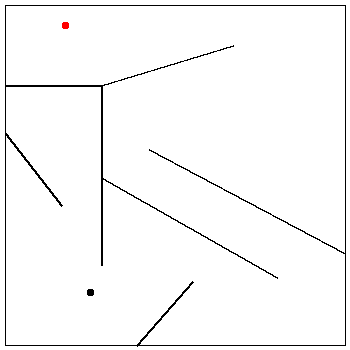

Step 396:


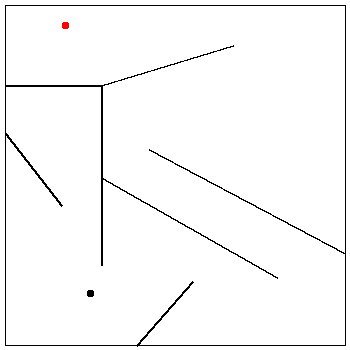

Step 397:


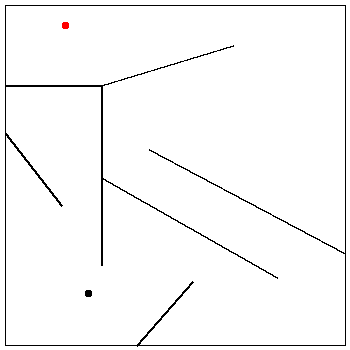

Step 398:


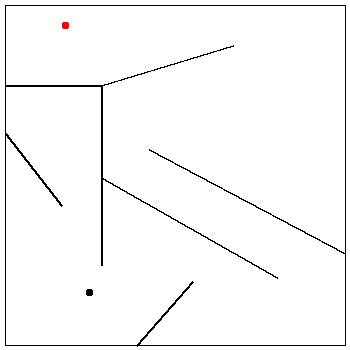

Step 399:


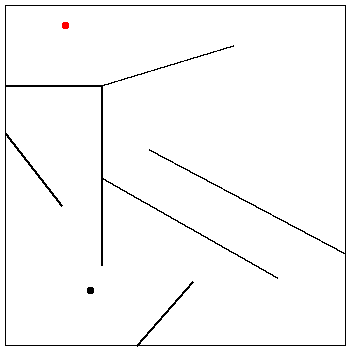

Step 400:


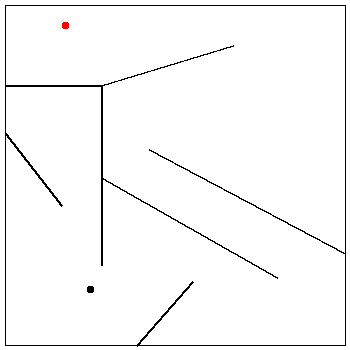

Timeout at 400 steps:


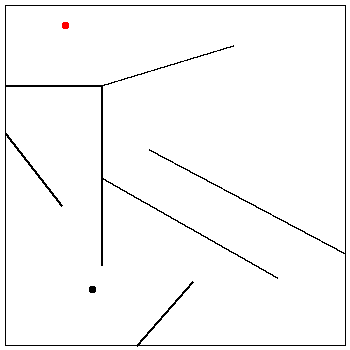

In [ ]:
#runSimulation(hardMaze, goStraightAvoid)
runSimulation(hardMaze, randomController)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
